In [1]:
import numpy as np
import pandas as pd
import os
import random
import warnings
from keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
import keras
from keras.layers import Embedding, Dense, LSTM
from keras.layers import Bidirectional
import matplotlib.pyplot as plt
from keras.layers import Input, Dense, BatchNormalization, Dropout, GaussianNoise, GaussianDropout
from keras.models import Model
from keras.utils import np_utils
from keras.callbacks import CSVLogger, History
import keras.backend as backend
from tensorflow.python.keras.utils.vis_utils import plot_model
from datetime import datetime
from tensorflow.keras.callbacks import Callback, TensorBoard
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.keras import layers
from keras_multi_head import MultiHead
import pickle

# Fig. 4 Eavaluation results in MTL4MHC2: MHC class II binding prediction by using multi-task learning.

## Used library
### Tensorflow, Keras, matplotlib, Pandas, Numpy, pickle, scikit-learn, keras_multi_head

## Could you download following files.

## Model(h5 file)
### Our datasets are available from [here](https://bioinformatics.riken.jp/MTL4MHC2/model/)

## other data
### embedding dictionary is available from [here](https://github.com/rikenbit/MTL4MHC2/tree/main/dict)



In [2]:
with open("{Path_to_pkl_file}/monovec.pkl","rb") as f:
     monovec = pickle.load(f)
    
with open("{Path_to_pkl_file}/trigram_to_idx_MHC.pkl","rb") as f:
    trigram_to_idx_MHC = pickle.load(f)

with open("{Path_to_pkl_file}/monogram_to_idx.pkl","rb") as f:
    monogram_to_idx = pickle.load(f)

with open("{Path_to_pkl_file}/trivec1_MHC.pkl","rb") as f:
    trivec1_MHC = pickle.load(f)

In [3]:
  def replace(raw_seq_0):
    B_aa = 'DN'
    J_aa = 'IL'
    Z_aa = 'EQ'
    X_aa = 'ACDEFGHIKLMNPQRSTVWY'
    
    seq = raw_seq_0.str.replace('B', random.choice(B_aa))
    seq = seq.str.replace('J', random.choice(J_aa))
    seq = seq.str.replace('Z', random.choice(Z_aa))
    seq = seq.str.replace('X', random.choice(X_aa))
    raw_seq_0 = seq
    
    return raw_seq_0

#monogram
def monogram(raw_seq_0):
    feature_0 = []
    for i in range(0, len(raw_seq_0)):
        strain_embedding = []
        for j in range(0, len(raw_seq_0[i])):
            monogram = raw_seq_0[i][j]
            mono_embedding = monogram_to_idx["".join(monogram)]
            strain_embedding.append(mono_embedding)
            
        feature_0.append(strain_embedding)
    return feature_0

#trigram
def trigram(raw_seq_0):
    feature_0 = []
    for i in range(0, len(raw_seq_0)):
        strain_embedding = []
        for j in range(0, len(raw_seq_0[i]) - 2):
            trigram = raw_seq_0[i][j:j + 3]
            tri_embedding = trigram_to_idx_MHC["".join(trigram)]
            strain_embedding.append(tri_embedding)
            
        feature_0.append(strain_embedding)
    return feature_0

# Dataset import

In [5]:
HLADRB10101test = "https://bioinformatics.riken.jp/MTL4MHC2/evaluation_dataset_IEDB/HLA-DRB1-0101_test.csv"
HLADRB10301test = "https://bioinformatics.riken.jp/MTL4MHC2/evaluation_dataset_IEDB/HLA-DRB1-0301_test.csv"
HLADRB10401test = "https://bioinformatics.riken.jp/MTL4MHC2/evaluation_dataset_IEDB/HLA-DRB1-0401_test.csv"
HLADRB10404test = "https://bioinformatics.riken.jp/MTL4MHC2/evaluation_dataset_IEDB/HLA-DRB1-0404_test.csv"
HLADRB10405test = "https://bioinformatics.riken.jp/MTL4MHC2/evaluation_dataset_IEDB/HLA-DRB1-0405_test.csv"
HLADRB10701test = "https://bioinformatics.riken.jp/MTL4MHC2/evaluation_dataset_IEDB/HLA-DRB1-0701_test.csv"
HLADRB10802test = "https://bioinformatics.riken.jp/MTL4MHC2/evaluation_dataset_IEDB/HLA-DRB1-0802_test.csv"
HLADRB10901test = "https://bioinformatics.riken.jp/MTL4MHC2/evaluation_dataset_IEDB/HLA-DRB1-0901_test.csv"
HLADRB11101test = "https://bioinformatics.riken.jp/MTL4MHC2/evaluation_dataset_IEDB/HLA-DRB1-1101_test.csv"
HLADRB11302test = "https://bioinformatics.riken.jp/MTL4MHC2/evaluation_dataset_IEDB/HLA-DRB1-1302_test.csv"
HLADRB11501test = "https://bioinformatics.riken.jp/MTL4MHC2/evaluation_dataset_IEDB/HLA-DRB1-1501_test.csv"
HLADRB30101test = "https://bioinformatics.riken.jp/MTL4MHC2/evaluation_dataset_IEDB/HLA-DRB3-0101_test.csv"
HLADRB40101test = "https://bioinformatics.riken.jp/MTL4MHC2/evaluation_dataset_IEDB/HLA-DRB4-0101_test.csv"
HLADRB50101test = "https://bioinformatics.riken.jp/MTL4MHC2/evaluation_dataset_IEDB/HLA-DRB5-0101_test.csv"

In [6]:
HLADRB10101test1 = pd.read_csv(HLADRB10101test)
HLADRB10301test1 = pd.read_csv(HLADRB10301test)
HLADRB10401test1 = pd.read_csv(HLADRB10401test)
HLADRB10404test1 = pd.read_csv(HLADRB10404test)
HLADRB10405test1 = pd.read_csv(HLADRB10405test)
HLADRB10701test1 = pd.read_csv(HLADRB10701test)
HLADRB10802test1 = pd.read_csv(HLADRB10802test)
HLADRB10901test1 = pd.read_csv(HLADRB10901test)
HLADRB11101test1 = pd.read_csv(HLADRB11101test)
HLADRB11302test1 = pd.read_csv(HLADRB11302test)
HLADRB11501test1 = pd.read_csv(HLADRB11501test)
HLADRB30101test1 = pd.read_csv(HLADRB30101test)
HLADRB40101test1 = pd.read_csv(HLADRB40101test)
HLADRB50101test1 = pd.read_csv(HLADRB50101test)

# Pretreatment

In [7]:
d = [0]*100
p =  np.array(['-'])
lp = np.array(d, dtype=float)
lps = np.append(p, lp)
lpsd = pd.DataFrame(lps).T

In [9]:
#HLADRB10101
HLADRB10101test_all = HLADRB10101test1.sample(frac=1).reset_index(drop=True)
HLADRB10101test_v = HLADRB10101test_all["peptide"]
HLADRB10101test_v_MHC = HLADRB10101test_all["mhc_amino_acid"]
HLADRB10101test_v = replace(HLADRB10101test_v)
HLADRB10101test_v_MHC = replace(HLADRB10101test_v_MHC)

HLADRB10101test_v = monogram(HLADRB10101test_v)
HLADRB10101test_v_MHC = trigram(HLADRB10101test_v_MHC)

HLADRB10101test_label = HLADRB10101test_all["bind"]
HLADRB10101test_label = pd.get_dummies(HLADRB10101test_label, sparse=True)



In [10]:
HLADRB10101test_v1 = pad_sequences(HLADRB10101test_v, maxlen=MAX_LEN_1)

HLADRB10101test_v1 = np.array(HLADRB10101test_v1)
HLADRB10101test_label = np.array(HLADRB10101test_label)

HLADRB10101test_v_MHC1 = pad_sequences(HLADRB10101test_v_MHC, maxlen=MAX_LEN_1MHC)
HLADRB10101test_v_MHC1 = np.array(HLADRB10101test_v_MHC1)


In [11]:
#HLADRB10301
HLADRB10301test_all = HLADRB10301test1.sample(frac=1).reset_index(drop=True)
HLADRB10301test_v = HLADRB10301test_all["peptide"]
HLADRB10301test_v_MHC = HLADRB10301test_all["mhc_amino_acid"]
HLADRB10301test_v = replace(HLADRB10301test_v)
HLADRB10301test_v_MHC = replace(HLADRB10301test_v_MHC)

HLADRB10301test_v = monogram(HLADRB10301test_v)
HLADRB10301test_v_MHC = trigram(HLADRB10301test_v_MHC)

HLADRB10301test_label = HLADRB10301test_all["bind"]
HLADRB10301test_label = pd.get_dummies(HLADRB10301test_label, sparse=True)

HLADRB10301test_v1 = pad_sequences(HLADRB10301test_v, maxlen=MAX_LEN_1)

HLADRB10301test_v1 = np.array(HLADRB10301test_v1)
HLADRB10301test_label = np.array(HLADRB10301test_label)

HLADRB10301test_v_MHC1 = pad_sequences(HLADRB10301test_v_MHC, maxlen=MAX_LEN_1MHC)
HLADRB10301test_v_MHC1 = np.array(HLADRB10301test_v_MHC1)

In [12]:
#HLADRB10401
HLADRB10401test_all = HLADRB10401test1.sample(frac=1).reset_index(drop=True)
HLADRB10401test_v = HLADRB10401test_all["peptide"]
HLADRB10401test_v_MHC = HLADRB10401test_all["mhc_amino_acid"]
HLADRB10401test_v = replace(HLADRB10401test_v)
HLADRB10401test_v_MHC = replace(HLADRB10401test_v_MHC)

HLADRB10401test_v = monogram(HLADRB10401test_v)
HLADRB10401test_v_MHC = trigram(HLADRB10401test_v_MHC)

HLADRB10401test_label = HLADRB10401test_all["bind"]
HLADRB10401test_label = pd.get_dummies(HLADRB10401test_label, sparse=True)

HLADRB10401test_v1 = pad_sequences(HLADRB10401test_v, maxlen=MAX_LEN_1)

HLADRB10401test_v1 = np.array(HLADRB10401test_v1)
HLADRB10401test_label = np.array(HLADRB10401test_label)

HLADRB10401test_v_MHC1 = pad_sequences(HLADRB10401test_v_MHC, maxlen=MAX_LEN_1MHC)
HLADRB10401test_v_MHC1 = np.array(HLADRB10401test_v_MHC1)

In [11]:
#HLADRB10404
HLADRB10404test_all = HLADRB10404test1.sample(frac=1).reset_index(drop=True)
HLADRB10404test_v = HLADRB10404test_all["peptide"]
HLADRB10404test_v_MHC = HLADRB10404test_all["mhc_amino_acid"]
HLADRB10404test_v = replace(HLADRB10404test_v)
HLADRB10404test_v_MHC = replace(HLADRB10404test_v_MHC)

HLADRB10404test_v = monogram(HLADRB10404test_v)
HLADRB10404test_v_MHC = trigram(HLADRB10404test_v_MHC)

HLADRB10404test_label = HLADRB10404test_all["bind"]
HLADRB10404test_label = pd.get_dummies(HLADRB10404test_label, sparse=True)

HLADRB10404test_v1 = pad_sequences(HLADRB10404test_v, maxlen=MAX_LEN_1)

HLADRB10404test_v1 = np.array(HLADRB10404test_v1)
HLADRB10404test_label = np.array(HLADRB10404test_label)

HLADRB10404test_v_MHC1 = pad_sequences(HLADRB10404test_v_MHC, maxlen=MAX_LEN_1MHC)
HLADRB10404test_v_MHC1 = np.array(HLADRB10404test_v_MHC1)

In [13]:
#HLADRB10405
HLADRB10405test_all = HLADRB10405test1.sample(frac=1).reset_index(drop=True)
HLADRB10405test_v = HLADRB10405test_all["peptide"]
HLADRB10405test_v_MHC = HLADRB10405test_all["mhc_amino_acid"]
HLADRB10405test_v = replace(HLADRB10405test_v)
HLADRB10405test_v_MHC = replace(HLADRB10405test_v_MHC)

HLADRB10405test_v = monogram(HLADRB10405test_v)
HLADRB10405test_v_MHC = trigram(HLADRB10405test_v_MHC)

HLADRB10405test_label = HLADRB10405test_all["bind"]
HLADRB10405test_label = pd.get_dummies(HLADRB10405test_label, sparse=True)

HLADRB10405test_v1 = pad_sequences(HLADRB10405test_v, maxlen=MAX_LEN_1)

HLADRB10405test_v1 = np.array(HLADRB10405test_v1)
HLADRB10405test_label = np.array(HLADRB10405test_label)

HLADRB10405test_v_MHC1 = pad_sequences(HLADRB10405test_v_MHC, maxlen=MAX_LEN_1MHC)
HLADRB10405test_v_MHC1 = np.array(HLADRB10405test_v_MHC1)

In [14]:
#HLADRB10701
HLADRB10701test_all = HLADRB10701test1.sample(frac=1).reset_index(drop=True)
HLADRB10701test_v = HLADRB10701test_all["peptide"]
HLADRB10701test_v_MHC = HLADRB10701test_all["mhc_amino_acid"]
HLADRB10701test_v = replace(HLADRB10701test_v)
HLADRB10701test_v_MHC = replace(HLADRB10701test_v_MHC)

HLADRB10701test_v = monogram(HLADRB10701test_v)
HLADRB10701test_v_MHC = trigram(HLADRB10701test_v_MHC)

HLADRB10701test_label = HLADRB10701test_all["bind"]
HLADRB10701test_label = pd.get_dummies(HLADRB10701test_label, sparse=True)

HLADRB10701test_v1 = pad_sequences(HLADRB10701test_v, maxlen=MAX_LEN_1)

HLADRB10701test_v1 = np.array(HLADRB10701test_v1)
HLADRB10701test_label = np.array(HLADRB10701test_label)

HLADRB10701test_v_MHC1 = pad_sequences(HLADRB10701test_v_MHC, maxlen=MAX_LEN_1MHC)
HLADRB10701test_v_MHC1 = np.array(HLADRB10701test_v_MHC1)

In [15]:
#HLADRB10802
HLADRB10802test_all = HLADRB10802test1.sample(frac=1).reset_index(drop=True)
HLADRB10802test_v = HLADRB10802test_all["peptide"]
HLADRB10802test_v_MHC = HLADRB10802test_all["mhc_amino_acid"]
HLADRB10802test_v = replace(HLADRB10802test_v)
HLADRB10802test_v_MHC = replace(HLADRB10802test_v_MHC)

HLADRB10802test_v = monogram(HLADRB10802test_v)
HLADRB10802test_v_MHC = trigram(HLADRB10802test_v_MHC)

HLADRB10802test_label = HLADRB10802test_all["bind"]
HLADRB10802test_label = pd.get_dummies(HLADRB10802test_label, sparse=True)

HLADRB10802test_v1 = pad_sequences(HLADRB10802test_v, maxlen=MAX_LEN_1)

HLADRB10802test_v1 = np.array(HLADRB10802test_v1)
HLADRB10802test_label = np.array(HLADRB10802test_label)

HLADRB10802test_v_MHC1 = pad_sequences(HLADRB10802test_v_MHC, maxlen=MAX_LEN_1MHC)
HLADRB10802test_v_MHC1 = np.array(HLADRB10802test_v_MHC1)

In [16]:
#HLADRB10901
HLADRB10901test_all = HLADRB10901test1.sample(frac=1).reset_index(drop=True)
HLADRB10901test_v = HLADRB10901test_all["peptide"]
HLADRB10901test_v_MHC = HLADRB10901test_all["mhc_amino_acid"]
HLADRB10901test_v = replace(HLADRB10901test_v)
HLADRB10901test_v_MHC = replace(HLADRB10901test_v_MHC)

HLADRB10901test_v = monogram(HLADRB10901test_v)
HLADRB10901test_v_MHC = trigram(HLADRB10901test_v_MHC)

HLADRB10901test_label = HLADRB10901test_all["bind"]
HLADRB10901test_label = pd.get_dummies(HLADRB10901test_label, sparse=True)

HLADRB10901test_v1 = pad_sequences(HLADRB10901test_v, maxlen=MAX_LEN_1)

HLADRB10901test_v1 = np.array(HLADRB10901test_v1)
HLADRB10901test_label = np.array(HLADRB10901test_label)

HLADRB10901test_v_MHC1 = pad_sequences(HLADRB10901test_v_MHC, maxlen=MAX_LEN_1MHC)
HLADRB10901test_v_MHC1 = np.array(HLADRB10901test_v_MHC1)

In [17]:
#HLADRB11101
HLADRB11101test_all = HLADRB11101test1.sample(frac=1).reset_index(drop=True)
HLADRB11101test_v = HLADRB11101test_all["peptide"]
HLADRB11101test_v_MHC = HLADRB11101test_all["mhc_amino_acid"]
HLADRB11101test_v = replace(HLADRB11101test_v)
HLADRB11101test_v_MHC = replace(HLADRB11101test_v_MHC)

HLADRB11101test_v = monogram(HLADRB11101test_v)
HLADRB11101test_v_MHC = trigram(HLADRB11101test_v_MHC)

HLADRB11101test_label = HLADRB11101test_all["bind"]
HLADRB11101test_label = pd.get_dummies(HLADRB11101test_label, sparse=True)

HLADRB11101test_v1 = pad_sequences(HLADRB11101test_v, maxlen=MAX_LEN_1)

HLADRB11101test_v1 = np.array(HLADRB11101test_v1)
HLADRB11101test_label = np.array(HLADRB11101test_label)

HLADRB11101test_v_MHC1 = pad_sequences(HLADRB11101test_v_MHC, maxlen=MAX_LEN_1MHC)
HLADRB11101test_v_MHC1 = np.array(HLADRB11101test_v_MHC1)

In [18]:
#HLADRB11302
HLADRB11302test_all = HLADRB11302test1.sample(frac=1).reset_index(drop=True)
HLADRB11302test_v = HLADRB11302test_all["peptide"]
HLADRB11302test_v_MHC = HLADRB11302test_all["mhc_amino_acid"]
HLADRB11302test_v = replace(HLADRB11302test_v)
HLADRB11302test_v_MHC = replace(HLADRB11302test_v_MHC)

HLADRB11302test_v = monogram(HLADRB11302test_v)
HLADRB11302test_v_MHC = trigram(HLADRB11302test_v_MHC)

HLADRB11302test_label = HLADRB11302test_all["bind"]
HLADRB11302test_label = pd.get_dummies(HLADRB11302test_label, sparse=True)

HLADRB11302test_v1 = pad_sequences(HLADRB11302test_v, maxlen=MAX_LEN_1)

HLADRB11302test_v1 = np.array(HLADRB11302test_v1)
HLADRB11302test_label = np.array(HLADRB11302test_label)

HLADRB11302test_v_MHC1 = pad_sequences(HLADRB11302test_v_MHC, maxlen=MAX_LEN_1MHC)
HLADRB11302test_v_MHC1 = np.array(HLADRB11302test_v_MHC1)

In [19]:
#HLADRB11501
HLADRB11501test_all = HLADRB11501test1.sample(frac=1).reset_index(drop=True)
HLADRB11501test_v = HLADRB11501test_all["peptide"]
HLADRB11501test_v_MHC = HLADRB11501test_all["mhc_amino_acid"]
HLADRB11501test_v = replace(HLADRB11501test_v)
HLADRB11501test_v_MHC = replace(HLADRB11501test_v_MHC)

HLADRB11501test_v = monogram(HLADRB11501test_v)
HLADRB11501test_v_MHC = trigram(HLADRB11501test_v_MHC)

HLADRB11501test_label = HLADRB11501test_all["bind"]
HLADRB11501test_label = pd.get_dummies(HLADRB11501test_label, sparse=True)

HLADRB11501test_v1 = pad_sequences(HLADRB11501test_v, maxlen=MAX_LEN_1)

HLADRB11501test_v1 = np.array(HLADRB11501test_v1)
HLADRB11501test_label = np.array(HLADRB11501test_label)

HLADRB11501test_v_MHC1 = pad_sequences(HLADRB11501test_v_MHC, maxlen=MAX_LEN_1MHC)
HLADRB11501test_v_MHC1 = np.array(HLADRB11501test_v_MHC1)

In [20]:
#HLADRB30101
HLADRB30101test_all = HLADRB30101test1.sample(frac=1).reset_index(drop=True)
HLADRB30101test_v = HLADRB30101test_all["peptide"]
HLADRB30101test_v_MHC = HLADRB30101test_all["mhc_amino_acid"]
HLADRB30101test_v = replace(HLADRB30101test_v)
HLADRB30101test_v_MHC = replace(HLADRB30101test_v_MHC)

HLADRB30101test_v = monogram(HLADRB30101test_v)
HLADRB30101test_v_MHC = trigram(HLADRB30101test_v_MHC)

HLADRB30101test_label = HLADRB30101test_all["bind"]
HLADRB30101test_label = pd.get_dummies(HLADRB30101test_label, sparse=True)

HLADRB30101test_v1 = pad_sequences(HLADRB30101test_v, maxlen=MAX_LEN_1)

HLADRB30101test_v1 = np.array(HLADRB30101test_v1)
HLADRB30101test_label = np.array(HLADRB30101test_label)

HLADRB30101test_v_MHC1 = pad_sequences(HLADRB30101test_v_MHC, maxlen=MAX_LEN_1MHC)
HLADRB30101test_v_MHC1 = np.array(HLADRB30101test_v_MHC1)

In [21]:
#HLADRB40101
HLADRB40101test_all = HLADRB40101test1.sample(frac=1).reset_index(drop=True)
HLADRB40101test_v = HLADRB40101test_all["peptide"]
HLADRB40101test_v_MHC = HLADRB40101test_all["mhc_amino_acid"]
HLADRB40101test_v = replace(HLADRB40101test_v)
HLADRB40101test_v_MHC = replace(HLADRB40101test_v_MHC)

HLADRB40101test_v = monogram(HLADRB40101test_v)
HLADRB40101test_v_MHC = trigram(HLADRB40101test_v_MHC)

HLADRB40101test_label = HLADRB40101test_all["bind"]
HLADRB40101test_label = pd.get_dummies(HLADRB40101test_label, sparse=True)

HLADRB40101test_v1 = pad_sequences(HLADRB40101test_v, maxlen=MAX_LEN_1)

HLADRB40101test_v1 = np.array(HLADRB40101test_v1)
HLADRB40101test_label = np.array(HLADRB40101test_label)

HLADRB40101test_v_MHC1 = pad_sequences(HLADRB40101test_v_MHC, maxlen=MAX_LEN_1MHC)
HLADRB40101test_v_MHC1 = np.array(HLADRB40101test_v_MHC1)

In [22]:
#HLADRB50101
HLADRB50101test_all = HLADRB50101test1.sample(frac=1).reset_index(drop=True)
HLADRB50101test_v = HLADRB50101test_all["peptide"]
HLADRB50101test_v_MHC = HLADRB50101test_all["mhc_amino_acid"]
HLADRB50101test_v = replace(HLADRB50101test_v)
HLADRB50101test_v_MHC = replace(HLADRB50101test_v_MHC)

HLADRB50101test_v = monogram(HLADRB50101test_v)
HLADRB50101test_v_MHC = trigram(HLADRB50101test_v_MHC)

HLADRB50101test_label = HLADRB50101test_all["bind"]
HLADRB50101test_label = pd.get_dummies(HLADRB50101test_label, sparse=True)

HLADRB50101test_v1 = pad_sequences(HLADRB50101test_v, maxlen=MAX_LEN_1)

HLADRB50101test_v1 = np.array(HLADRB50101test_v1)
HLADRB50101test_label = np.array(HLADRB50101test_label)

HLADRB50101test_v_MHC1 = pad_sequences(HLADRB50101test_v_MHC, maxlen=MAX_LEN_1MHC)
HLADRB50101test_v_MHC1 = np.array(HLADRB50101test_v_MHC1)

# Multi-task Bi-LSTM

In [4]:
def multi_bilstm(out_dim1, dropoutrate, out_dim2, out_dim3, out_dim4, loss1, loss2):
    shared_embedding = Embedding(47, 100, weights=[monovec], trainable=False)
    sharedLSTM1 = LSTM(out_dim1, dropout=dropoutrate, return_sequences=True)
    sharedLSTM2 = LSTM(out_dim2,dropout=dropoutrate)
    sharedLSTM_bw1 = LSTM(out_dim1, dropout=dropoutrate, return_sequences=True, go_backwards=True)
    sharedLSTM_bw2 = LSTM(out_dim2, dropout=dropoutrate, go_backwards=True)
    
    shared_embedding_MHC = Embedding(9419, 100, input_length=230, weights=[trivec1_MHC], trainable=False)
    sharedLSTM1_MHC = LSTM(out_dim3, dropout=dropoutrate, return_sequences=True)
    sharedLSTM2_MHC = LSTM(out_dim4,dropout=dropoutrate)
    sharedLSTM_bw1_MHC = LSTM(out_dim3, dropout=dropoutrate, return_sequences=True, go_backwards=True)
    sharedLSTM_bw2_MHC = LSTM(out_dim4, dropout=dropoutrate, go_backwards=True)
    
    
    
    text_input_c1 = keras.Input(shape=(None,))
    text_input_c2 = keras.Input(shape=(None,))
    
    encoded_input_c1 = shared_embedding(text_input_c1)
    encoded_input_c2 = shared_embedding(text_input_c2)
    
    #class I
    sharedLSTM1Instance_c1 = sharedLSTM1(encoded_input_c1)
    sharedLSTM_bw1Instance_c1 = sharedLSTM_bw1(encoded_input_c1)
    BiLSTM_c1_output_1 = layers.concatenate([sharedLSTM1Instance_c1, sharedLSTM_bw1Instance_c1], axis=-1)
    sharedLSTM2Instance_c1 =  sharedLSTM2(BiLSTM_c1_output_1)
    sharedLSTM_bw2Instance_c1 =  sharedLSTM_bw2(BiLSTM_c1_output_1)
    BiLSTM_c1_output_2 = layers.concatenate([sharedLSTM2Instance_c1, sharedLSTM_bw2Instance_c1])
    BiLSTM_c1_output_3 = Dense(64, activation='relu')(BiLSTM_c1_output_2)



    
    # class II
    sharedLSTM1Instance_c2 = sharedLSTM1(encoded_input_c2)
    sharedLSTM_bw1Instance_c2 = sharedLSTM_bw1(encoded_input_c2)
    BiLSTM_c2_output_1 = layers.concatenate([sharedLSTM1Instance_c2, sharedLSTM_bw1Instance_c2], axis=-1)
    sharedLSTM2Instance_c2 =  sharedLSTM2(BiLSTM_c2_output_1)
    sharedLSTM_bw2Instance_c2 =  sharedLSTM_bw2(BiLSTM_c2_output_1)
    BiLSTM_c2_output_2 = layers.concatenate([sharedLSTM2Instance_c2, sharedLSTM_bw2Instance_c2])
    BiLSTM_c2_output_3 = Dense(64, activation='relu')(BiLSTM_c2_output_2)


    
    text_input_c1_MHC = keras.Input(shape=(None,))
    text_input_c2_MHC = keras.Input(shape=(None,))
    
    encoded_input_c1_MHC = shared_embedding_MHC(text_input_c1_MHC)
    encoded_input_c2_MHC = shared_embedding_MHC(text_input_c2_MHC)
    
    #class I
    sharedLSTM1Instance_c1_MHC = sharedLSTM1_MHC(encoded_input_c1_MHC)
    sharedLSTM_bw1Instance_c1_MHC = sharedLSTM_bw1_MHC(encoded_input_c1_MHC)
    BiLSTM_c1_output_1_MHC = layers.concatenate([sharedLSTM1Instance_c1_MHC, sharedLSTM_bw1Instance_c1_MHC], axis=-1)
    sharedLSTM2Instance_c1_MHC =  sharedLSTM2_MHC(BiLSTM_c1_output_1_MHC)
    sharedLSTM_bw2Instance_c1_MHC =  sharedLSTM_bw2_MHC(BiLSTM_c1_output_1_MHC)
    BiLSTM_c1_output_2_MHC = layers.concatenate([sharedLSTM2Instance_c1_MHC, sharedLSTM_bw2Instance_c1_MHC])
    BiLSTM_c1_output_3_MHC = Dense(64, activation='relu')(BiLSTM_c1_output_2_MHC)


    
    # class II
    sharedLSTM1Instance_c2_MHC = sharedLSTM1_MHC(encoded_input_c2_MHC)
    sharedLSTM_bw1Instance_c2_MHC = sharedLSTM_bw1_MHC(encoded_input_c2_MHC)
    BiLSTM_c2_output_1_MHC = layers.concatenate([sharedLSTM1Instance_c2_MHC, sharedLSTM_bw1Instance_c2_MHC], axis=-1)
    sharedLSTM2Instance_c2_MHC =  sharedLSTM2_MHC(BiLSTM_c2_output_1_MHC)
    sharedLSTM_bw2Instance_c2_MHC =  sharedLSTM_bw2_MHC(BiLSTM_c2_output_1_MHC)
    BiLSTM_c2_output_2_MHC = layers.concatenate([sharedLSTM2Instance_c2_MHC, sharedLSTM_bw2Instance_c2_MHC])
    BiLSTM_c2_output_3_MHC = Dense(64, activation='relu')(BiLSTM_c2_output_2_MHC)
    
    
    conc1 = layers.concatenate([BiLSTM_c1_output_3, BiLSTM_c1_output_3_MHC], axis=-1)
    conc2 = layers.concatenate([BiLSTM_c2_output_3, BiLSTM_c2_output_3_MHC], axis=-1)
    out1 = Dense(2, activation='softmax')(conc1)
    out2 = Dense(2, activation='softmax')(conc2)
    
    
    model = Model([text_input_c1, text_input_c2, text_input_c1_MHC, text_input_c2_MHC], outputs=[out1, out2])  
    model.compile(loss=['binary_crossentropy', 'binary_crossentropy',], loss_weights=[loss1, loss2], optimizer="adam", metrics=['accuracy', 'AUC', 'Recall', 'Precision'])
    
    
    
    return model

In [8]:
model = multi_bilstm(out_dim1=128, dropoutrate=0.6, out_dim2=128, out_dim3=128, out_dim4=128, loss1=10, loss2=90)
model.load_weights('{Path_to_h5_file}/task_lstm_t1_128_weights.h5')

In [31]:
t = model.predict([HLADRB10101test_v1, HLADRB10101test_v1, HLADRB10101test_v_MHC1, HLADRB10101test_v_MHC1], verbose=0)
t = pd.DataFrame(t[1])

In [34]:
t = t[0]

test = pd.DataFrame(HLADRB10101test_label)
test = test[0]

In [38]:
TP = K.sum(K.round(test* t))
TN = K.sum(K.cast(K.equal(K.round(test+ t), 0), K.floatx()))
FP = K.sum(K.cast(K.equal(K.round(t) - test, 1), K.floatx()))
FN = K.sum(K.cast(K.equal(test- K.round(t), 1), K.floatx()))

accuracy = (TP+TN)/(TP+FN+FP+TN)
recall = TP/(TP+FN)
precision = TP/(TP+FP)
F1 = (2*precision*recall)/(precision + recall)
from sklearn.metrics import roc_auc_score 
roc_auc = roc_auc_score(test, t)
task_lstm_t1_128_HLADRB10101re = [TP, TN, FP, FN, accuracy, recall, precision, F1, roc_auc]
task_lstm_t1_128_HLADRB10101re = pd.DataFrame(task_lstm_t1_128_HLADRB10101re).T

display(task_lstm_t1_128_HLADRB10101re)

,0,1,2,3,4,5,6,7,8
0,1394.0,3822.0,697.0,514.0,0.811576,0.730608,0.666667,0.697174,0.85738


In [39]:
task_lstm_t1_128_HLADRB10101re.columns = ['TP', 'TN', 'FP', 'FN', 'accuracy', 'recall', 'precision', 'F1-score', 'AUC-ROC']
display(task_lstm_t1_128_HLADRB10101re)

,TP,TN,FP,FN,accuracy,recall,precision,F1-score,AUC-ROC
0,1394.0,3822.0,697.0,514.0,0.811576,0.730608,0.666667,0.697174,0.85738


In [41]:
t = model.predict([HLADRB10301test_v1, HLADRB10301test_v1,HLADRB10301test_v_MHC1, HLADRB10301test_v_MHC1], verbose=0)
t = pd.DataFrame(t[1])
t = t[0]

test = pd.DataFrame(HLADRB10301test_label)
test = test[0]

TP = K.sum(K.round(test* t))
TN = K.sum(K.cast(K.equal(K.round(test+ t), 0), K.floatx()))
FP = K.sum(K.cast(K.equal(K.round(t) - test, 1), K.floatx()))
FN = K.sum(K.cast(K.equal(test- K.round(t), 1), K.floatx()))

accuracy = (TP+TN)/(TP+FN+FP+TN)
recall = TP/(TP+FN)
precision = TP/(TP+FP)
F1 = (2*precision*recall)/(precision + recall)
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(test, t)
task_lstm_t1_128_HLADRB10301re = [TP, TN, FP, FN, accuracy, recall, precision, F1, roc_auc]
task_lstm_t1_128_HLADRB10301re = pd.DataFrame(task_lstm_t1_128_HLADRB10301re).T
task_lstm_t1_128_HLADRB10301re.columns = ['TP', 'TN', 'FP', 'FN', 'accuracy', 'recall', 'precision', 'F1-score', 'AUC-ROC']
display(task_lstm_t1_128_HLADRB10301re)

,TP,TN,FP,FN,accuracy,recall,precision,F1-score,AUC-ROC
0,584.0,458.0,95.0,578.0,0.60758,0.502582,0.860088,0.634438,0.754911


In [42]:
t = model.predict([HLADRB10401test_v1, HLADRB10401test_v1,HLADRB10401test_v_MHC1, HLADRB10401test_v_MHC1], verbose=0)
t = pd.DataFrame(t[1])
t = t[0]

test = pd.DataFrame(HLADRB10401test_label)
test = test[0]

TP = K.sum(K.round(test* t))
TN = K.sum(K.cast(K.equal(K.round(test+ t), 0), K.floatx()))
FP = K.sum(K.cast(K.equal(K.round(t) - test, 1), K.floatx()))
FN = K.sum(K.cast(K.equal(test- K.round(t), 1), K.floatx()))

accuracy = (TP+TN)/(TP+FN+FP+TN)
recall = TP/(TP+FN)
precision = TP/(TP+FP)
F1 = (2*precision*recall)/(precision + recall)
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(test, t)
task_lstm_t1_128_HLADRB10401re = [TP, TN, FP, FN, accuracy, recall, precision, F1, roc_auc]
task_lstm_t1_128_HLADRB10401re = pd.DataFrame(task_lstm_t1_128_HLADRB10401re).T
task_lstm_t1_128_HLADRB10401re.columns = ['TP', 'TN', 'FP', 'FN', 'accuracy', 'recall', 'precision', 'F1-score', 'AUC-ROC']
display(task_lstm_t1_128_HLADRB10401re)

,TP,TN,FP,FN,accuracy,recall,precision,F1-score,AUC-ROC
0,512.0,792.0,186.0,279.0,0.73714,0.647282,0.733524,0.68771,0.798054


In [26]:
model = multi_bilstm(out_dim1=128, dropoutrate=0.6, out_dim2=128, out_dim3=128, out_dim4=128, loss1=10, loss2=90)
model.load_weights('D:/ネオアンチゲン研究/multi task learning/モデル最適化/task_lstm_t1/task_lstm_t1_128.hdf5')
t = model.predict([HLADRB10404test_v1, HLADRB10404test_v1,HLADRB10404test_v_MHC1, HLADRB10404test_v_MHC1], verbose=0)
t = pd.DataFrame(t[1])
t = t[0]

test = pd.DataFrame(HLADRB10404test_label)
test = test[0]

TP = K.sum(K.round(test* t))
TN = K.sum(K.cast(K.equal(K.round(test+ t), 0), K.floatx()))
FP = K.sum(K.cast(K.equal(K.round(t) - test, 1), K.floatx()))
FN = K.sum(K.cast(K.equal(test- K.round(t), 1), K.floatx()))

accuracy = (TP+TN)/(TP+FN+FP+TN)
recall = TP/(TP+FN)
precision = TP/(TP+FP)
F1 = (2*precision*recall)/(precision + recall)
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(test, t)
task_lstm_t1_128_HLADRB10404re = [TP, TN, FP, FN, accuracy, recall, precision, F1, roc_auc]
task_lstm_t1_128_HLADRB10404re = pd.DataFrame(task_lstm_t1_128_HLADRB10404re).T
task_lstm_t1_128_HLADRB10404re.columns = ['TP', 'TN', 'FP', 'FN', 'accuracy', 'recall', 'precision', 'F1-score', 'AUC-ROC']
display(task_lstm_t1_128_HLADRB10404re)

,TP,TN,FP,FN,accuracy,recall,precision,F1-score,AUC-ROC
0,93.0,368.0,28.0,88.0,0.79896,0.513812,0.768595,0.615894,0.803323


In [43]:
t = model.predict([HLADRB10405test_v1, HLADRB10405test_v1,HLADRB10405test_v_MHC1, HLADRB10405test_v_MHC1], verbose=0)
t = pd.DataFrame(t[1])
t = t[0]

test = pd.DataFrame(HLADRB10405test_label)
test = test[0]

TP = K.sum(K.round(test* t))
TN = K.sum(K.cast(K.equal(K.round(test+ t), 0), K.floatx()))
FP = K.sum(K.cast(K.equal(K.round(t) - test, 1), K.floatx()))
FN = K.sum(K.cast(K.equal(test- K.round(t), 1), K.floatx()))

accuracy = (TP+TN)/(TP+FN+FP+TN)
recall = TP/(TP+FN)
precision = TP/(TP+FP)
F1 = (2*precision*recall)/(precision + recall)
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(test, t)
task_lstm_t1_128_HLADRB10405re = [TP, TN, FP, FN, accuracy, recall, precision, F1, roc_auc]
task_lstm_t1_128_HLADRB10405re = pd.DataFrame(task_lstm_t1_128_HLADRB10405re).T
task_lstm_t1_128_HLADRB10405re.columns = ['TP', 'TN', 'FP', 'FN', 'accuracy', 'recall', 'precision', 'F1-score', 'AUC-ROC']
display(task_lstm_t1_128_HLADRB10405re)

,TP,TN,FP,FN,accuracy,recall,precision,F1-score,AUC-ROC
0,531.0,656.0,150.0,245.0,0.750316,0.684278,0.779736,0.728895,0.813915


In [44]:
t = model.predict([HLADRB10701test_v1, HLADRB10701test_v1,HLADRB10701test_v_MHC1, HLADRB10701test_v_MHC1], verbose=0)
t = pd.DataFrame(t[1])
t = t[0]

test = pd.DataFrame(HLADRB10701test_label)
test = test[0]

TP = K.sum(K.round(test* t))
TN = K.sum(K.cast(K.equal(K.round(test+ t), 0), K.floatx()))
FP = K.sum(K.cast(K.equal(K.round(t) - test, 1), K.floatx()))
FN = K.sum(K.cast(K.equal(test- K.round(t), 1), K.floatx()))

accuracy = (TP+TN)/(TP+FN+FP+TN)
recall = TP/(TP+FN)
precision = TP/(TP+FP)
F1 = (2*precision*recall)/(precision + recall)
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(test, t)
task_lstm_t1_128_HLADRB10701re = [TP, TN, FP, FN, accuracy, recall, precision, F1, roc_auc]
task_lstm_t1_128_HLADRB10701re = pd.DataFrame(task_lstm_t1_128_HLADRB10701re).T
task_lstm_t1_128_HLADRB10701re.columns = ['TP', 'TN', 'FP', 'FN', 'accuracy', 'recall', 'precision', 'F1-score', 'AUC-ROC']
display(task_lstm_t1_128_HLADRB10701re)

,TP,TN,FP,FN,accuracy,recall,precision,F1-score,AUC-ROC
0,514.0,851.0,182.0,198.0,0.782235,0.72191,0.738506,0.730114,0.832453


In [45]:
t = model.predict([HLADRB10802test_v1, HLADRB10802test_v1,HLADRB10802test_v_MHC1, HLADRB10802test_v_MHC1], verbose=0)
t = pd.DataFrame(t[1])
t = t[0]

test = pd.DataFrame(HLADRB10802test_label)
test = test[0]

TP = K.sum(K.round(test* t))
TN = K.sum(K.cast(K.equal(K.round(test+ t), 0), K.floatx()))
FP = K.sum(K.cast(K.equal(K.round(t) - test, 1), K.floatx()))
FN = K.sum(K.cast(K.equal(test- K.round(t), 1), K.floatx()))

accuracy = (TP+TN)/(TP+FN+FP+TN)
recall = TP/(TP+FN)
precision = TP/(TP+FP)
F1 = (2*precision*recall)/(precision + recall)
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(test, t)
task_lstm_t1_128_HLADRB10802re = [TP, TN, FP, FN, accuracy, recall, precision, F1, roc_auc]
task_lstm_t1_128_HLADRB10802re = pd.DataFrame(task_lstm_t1_128_HLADRB10802re).T
task_lstm_t1_128_HLADRB10802re.columns = ['TP', 'TN', 'FP', 'FN', 'accuracy', 'recall', 'precision', 'F1-score', 'AUC-ROC']
display(task_lstm_t1_128_HLADRB10802re)

,TP,TN,FP,FN,accuracy,recall,precision,F1-score,AUC-ROC
0,544.0,473.0,118.0,385.0,0.669079,0.585576,0.821752,0.683847,0.758715


In [46]:
t = model.predict([HLADRB10901test_v1, HLADRB10901test_v1,HLADRB10901test_v_MHC1, HLADRB10901test_v_MHC1], verbose=0)
t = pd.DataFrame(t[1])
t = t[0]

test = pd.DataFrame(HLADRB10901test_label)
test = test[0]

TP = K.sum(K.round(test* t))
TN = K.sum(K.cast(K.equal(K.round(test+ t), 0), K.floatx()))
FP = K.sum(K.cast(K.equal(K.round(t) - test, 1), K.floatx()))
FN = K.sum(K.cast(K.equal(test- K.round(t), 1), K.floatx()))

accuracy = (TP+TN)/(TP+FN+FP+TN)
recall = TP/(TP+FN)
precision = TP/(TP+FP)
F1 = (2*precision*recall)/(precision + recall)
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(test, t)
task_lstm_t1_128_HLADRB10901re = [TP, TN, FP, FN, accuracy, recall, precision, F1, roc_auc]
task_lstm_t1_128_HLADRB10901re = pd.DataFrame(task_lstm_t1_128_HLADRB10901re).T
task_lstm_t1_128_HLADRB10901re.columns = ['TP', 'TN', 'FP', 'FN', 'accuracy', 'recall', 'precision', 'F1-score', 'AUC-ROC']
display(task_lstm_t1_128_HLADRB10901re)

,TP,TN,FP,FN,accuracy,recall,precision,F1-score,AUC-ROC
0,468.0,621.0,194.0,237.0,0.716447,0.66383,0.706949,0.684711,0.773758


In [47]:
t = model.predict([HLADRB11101test_v1, HLADRB11101test_v1,HLADRB11101test_v_MHC1, HLADRB11101test_v_MHC1], verbose=0)
t = pd.DataFrame(t[1])
t = t[0]

test = pd.DataFrame(HLADRB11101test_label)
test = test[0]

TP = K.sum(K.round(test* t))
TN = K.sum(K.cast(K.equal(K.round(test+ t), 0), K.floatx()))
FP = K.sum(K.cast(K.equal(K.round(t) - test, 1), K.floatx()))
FN = K.sum(K.cast(K.equal(test- K.round(t), 1), K.floatx()))

accuracy = (TP+TN)/(TP+FN+FP+TN)
recall = TP/(TP+FN)
precision = TP/(TP+FP)
F1 = (2*precision*recall)/(precision + recall)
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(test, t)
task_lstm_t1_128_HLADRB11101re = [TP, TN, FP, FN, accuracy, recall, precision, F1, roc_auc]
task_lstm_t1_128_HLADRB11101re = pd.DataFrame(task_lstm_t1_128_HLADRB11101re).T
task_lstm_t1_128_HLADRB11101re.columns = ['TP', 'TN', 'FP', 'FN', 'accuracy', 'recall', 'precision', 'F1-score', 'AUC-ROC']
display(task_lstm_t1_128_HLADRB11101re)

,TP,TN,FP,FN,accuracy,recall,precision,F1-score,AUC-ROC
0,559.0,796.0,161.0,278.0,0.755295,0.667861,0.776389,0.718047,0.820164


In [48]:
t = model.predict([HLADRB11302test_v1, HLADRB11302test_v1,HLADRB11302test_v_MHC1, HLADRB11302test_v_MHC1], verbose=0)
t = pd.DataFrame(t[1])
t = t[0]

test = pd.DataFrame(HLADRB11302test_label)
test = test[0]

TP = K.sum(K.round(test* t))
TN = K.sum(K.cast(K.equal(K.round(test+ t), 0), K.floatx()))
FP = K.sum(K.cast(K.equal(K.round(t) - test, 1), K.floatx()))
FN = K.sum(K.cast(K.equal(test- K.round(t), 1), K.floatx()))

accuracy = (TP+TN)/(TP+FN+FP+TN)
recall = TP/(TP+FN)
precision = TP/(TP+FP)
F1 = (2*precision*recall)/(precision + recall)
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(test, t)
task_lstm_t1_128_HLADRB11302re = [TP, TN, FP, FN, accuracy, recall, precision, F1, roc_auc]
task_lstm_t1_128_HLADRB11302re = pd.DataFrame(task_lstm_t1_128_HLADRB11302re).T
task_lstm_t1_128_HLADRB11302re.columns = ['TP', 'TN', 'FP', 'FN', 'accuracy', 'recall', 'precision', 'F1-score', 'AUC-ROC']
display(task_lstm_t1_128_HLADRB11302re)

,TP,TN,FP,FN,accuracy,recall,precision,F1-score,AUC-ROC
0,548.0,523.0,133.0,376.0,0.677848,0.593074,0.804699,0.682866,0.759601


In [49]:
t = model.predict([HLADRB11501test_v1, HLADRB11501test_v1,HLADRB11501test_v_MHC1, HLADRB11501test_v_MHC1], verbose=0)
t = pd.DataFrame(t[1])
t = t[0]

test = pd.DataFrame(HLADRB11501test_label)
test = test[0]

TP = K.sum(K.round(test* t))
TN = K.sum(K.cast(K.equal(K.round(test+ t), 0), K.floatx()))
FP = K.sum(K.cast(K.equal(K.round(t) - test, 1), K.floatx()))
FN = K.sum(K.cast(K.equal(test- K.round(t), 1), K.floatx()))

accuracy = (TP+TN)/(TP+FN+FP+TN)
recall = TP/(TP+FN)
precision = TP/(TP+FP)
F1 = (2*precision*recall)/(precision + recall)
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(test, t)
task_lstm_t1_128_HLADRB11501re = [TP, TN, FP, FN, accuracy, recall, precision, F1, roc_auc]
task_lstm_t1_128_HLADRB11501re = pd.DataFrame(task_lstm_t1_128_HLADRB11501re).T
task_lstm_t1_128_HLADRB11501re.columns = ['TP', 'TN', 'FP', 'FN', 'accuracy', 'recall', 'precision', 'F1-score', 'AUC-ROC']
display(task_lstm_t1_128_HLADRB11501re)

,TP,TN,FP,FN,accuracy,recall,precision,F1-score,AUC-ROC
0,592.0,690.0,125.0,362.0,0.724703,0.620545,0.825662,0.708558,0.809527


In [50]:
t = model.predict([HLADRB30101test_v1, HLADRB30101test_v1,HLADRB30101test_v_MHC1, HLADRB30101test_v_MHC1], verbose=0)
t = pd.DataFrame(t[1])
t = t[0]

test = pd.DataFrame(HLADRB30101test_label)
test = test[0]

TP = K.sum(K.round(test* t))
TN = K.sum(K.cast(K.equal(K.round(test+ t), 0), K.floatx()))
FP = K.sum(K.cast(K.equal(K.round(t) - test, 1), K.floatx()))
FN = K.sum(K.cast(K.equal(test- K.round(t), 1), K.floatx()))

accuracy = (TP+TN)/(TP+FN+FP+TN)
recall = TP/(TP+FN)
precision = TP/(TP+FP)
F1 = (2*precision*recall)/(precision + recall)
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(test, t)
task_lstm_t1_128_HLADRB30101re = [TP, TN, FP, FN, accuracy, recall, precision, F1, roc_auc]
task_lstm_t1_128_HLADRB30101re = pd.DataFrame(task_lstm_t1_128_HLADRB30101re).T
task_lstm_t1_128_HLADRB30101re.columns = ['TP', 'TN', 'FP', 'FN', 'accuracy', 'recall', 'precision', 'F1-score', 'AUC-ROC']
display(task_lstm_t1_128_HLADRB30101re)

,TP,TN,FP,FN,accuracy,recall,precision,F1-score,AUC-ROC
0,547.0,318.0,108.0,528.0,0.576283,0.508837,0.835114,0.63237,0.670868


In [51]:
t = model.predict([HLADRB40101test_v1, HLADRB40101test_v1,HLADRB40101test_v_MHC1, HLADRB40101test_v_MHC1], verbose=0)
t = pd.DataFrame(t[1])
t = t[0]

test = pd.DataFrame(HLADRB40101test_label)
test = test[0]

TP = K.sum(K.round(test* t))
TN = K.sum(K.cast(K.equal(K.round(test+ t), 0), K.floatx()))
FP = K.sum(K.cast(K.equal(K.round(t) - test, 1), K.floatx()))
FN = K.sum(K.cast(K.equal(test- K.round(t), 1), K.floatx()))

accuracy = (TP+TN)/(TP+FN+FP+TN)
recall = TP/(TP+FN)
precision = TP/(TP+FP)
F1 = (2*precision*recall)/(precision + recall)
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(test, t)
task_lstm_t1_128_HLADRB40101re = [TP, TN, FP, FN, accuracy, recall, precision, F1, roc_auc]
task_lstm_t1_128_HLADRB40101re = pd.DataFrame(task_lstm_t1_128_HLADRB40101re).T
task_lstm_t1_128_HLADRB40101re.columns = ['TP', 'TN', 'FP', 'FN', 'accuracy', 'recall', 'precision', 'F1-score', 'AUC-ROC']
display(task_lstm_t1_128_HLADRB40101re)

,TP,TN,FP,FN,accuracy,recall,precision,F1-score,AUC-ROC
0,517.0,509.0,145.0,350.0,0.674556,0.596309,0.780967,0.676259,0.764247


In [52]:
t = model.predict([HLADRB50101test_v1, HLADRB50101test_v1,HLADRB50101test_v_MHC1, HLADRB50101test_v_MHC1], verbose=0)
t = pd.DataFrame(t[1])
t = t[0]

test = pd.DataFrame(HLADRB50101test_label)
test = test[0]

TP = K.sum(K.round(test* t))
TN = K.sum(K.cast(K.equal(K.round(test+ t), 0), K.floatx()))
FP = K.sum(K.cast(K.equal(K.round(t) - test, 1), K.floatx()))
FN = K.sum(K.cast(K.equal(test- K.round(t), 1), K.floatx()))

accuracy = (TP+TN)/(TP+FN+FP+TN)
recall = TP/(TP+FN)
precision = TP/(TP+FP)
F1 = (2*precision*recall)/(precision + recall)
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(test, t)
task_lstm_t1_128_HLADRB50101re = [TP, TN, FP, FN, accuracy, recall, precision, F1, roc_auc]
task_lstm_t1_128_HLADRB50101re = pd.DataFrame(task_lstm_t1_128_HLADRB50101re).T
task_lstm_t1_128_HLADRB50101re.columns = ['TP', 'TN', 'FP', 'FN', 'accuracy', 'recall', 'precision', 'F1-score', 'AUC-ROC']
display(task_lstm_t1_128_HLADRB50101re)

,TP,TN,FP,FN,accuracy,recall,precision,F1-score,AUC-ROC
0,530.0,805.0,187.0,247.0,0.754664,0.682111,0.739191,0.709505,0.809423


# task_lstm_t1_256

In [27]:
model = multi_bilstm(out_dim1=256, dropoutrate=0.6, out_dim2=256, out_dim3=256, out_dim4=256, loss1=10, loss2=90)
model.load_weights('{Path_to_h5_file}/task_lstm_t1_256.hdf5')

In [54]:
t = model.predict([HLADRB10101test_v1, HLADRB10101test_v1, HLADRB10101test_v_MHC1, HLADRB10101test_v_MHC1], verbose=0)
t = pd.DataFrame(t[1])
t = t[0]

test = pd.DataFrame(HLADRB10101test_label)
test = test[0]

TP = K.sum(K.round(test* t))
TN = K.sum(K.cast(K.equal(K.round(test+ t), 0), K.floatx()))
FP = K.sum(K.cast(K.equal(K.round(t) - test, 1), K.floatx()))
FN = K.sum(K.cast(K.equal(test- K.round(t), 1), K.floatx()))

accuracy = (TP+TN)/(TP+FN+FP+TN)
recall = TP/(TP+FN)
precision = TP/(TP+FP)
F1 = (2*precision*recall)/(precision + recall)
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(test, t)
task_lstm_t1_256_HLADRB10101re = [TP, TN, FP, FN, accuracy, recall, precision, F1, roc_auc]
task_lstm_t1_256_HLADRB10101re = pd.DataFrame(task_lstm_t1_256_HLADRB10101re).T
task_lstm_t1_256_HLADRB10101re.columns = ['TP', 'TN', 'FP', 'FN', 'accuracy', 'recall', 'precision', 'F1-score', 'AUC-ROC']
display(task_lstm_t1_256_HLADRB10101re)


,TP,TN,FP,FN,accuracy,recall,precision,F1-score,AUC-ROC
0,1300.0,4006.0,513.0,608.0,0.82558,0.681342,0.717044,0.698737,0.858789


In [55]:
t = model.predict([HLADRB10301test_v1, HLADRB10301test_v1,HLADRB10301test_v_MHC1, HLADRB10301test_v_MHC1], verbose=0)
t = pd.DataFrame(t[1])
t = t[0]

test = pd.DataFrame(HLADRB10301test_label)
test = test[0]

TP = K.sum(K.round(test* t))
TN = K.sum(K.cast(K.equal(K.round(test+ t), 0), K.floatx()))
FP = K.sum(K.cast(K.equal(K.round(t) - test, 1), K.floatx()))
FN = K.sum(K.cast(K.equal(test- K.round(t), 1), K.floatx()))

accuracy = (TP+TN)/(TP+FN+FP+TN)
recall = TP/(TP+FN)
precision = TP/(TP+FP)
F1 = (2*precision*recall)/(precision + recall)
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(test, t)
task_lstm_t1_256_HLADRB10301re = [TP, TN, FP, FN, accuracy, recall, precision, F1, roc_auc]
task_lstm_t1_256_HLADRB10301re = pd.DataFrame(task_lstm_t1_256_HLADRB10301re).T
task_lstm_t1_256_HLADRB10301re.columns = ['TP', 'TN', 'FP', 'FN', 'accuracy', 'recall', 'precision', 'F1-score', 'AUC-ROC']
display(task_lstm_t1_256_HLADRB10301re)

,TP,TN,FP,FN,accuracy,recall,precision,F1-score,AUC-ROC
0,565.0,483.0,70.0,597.0,0.611079,0.486231,0.889764,0.628826,0.755255


In [56]:
t = model.predict([HLADRB10401test_v1, HLADRB10401test_v1,HLADRB10401test_v_MHC1, HLADRB10401test_v_MHC1], verbose=0)
t = pd.DataFrame(t[1])
t = t[0]

test = pd.DataFrame(HLADRB10401test_label)
test = test[0]

TP = K.sum(K.round(test* t))
TN = K.sum(K.cast(K.equal(K.round(test+ t), 0), K.floatx()))
FP = K.sum(K.cast(K.equal(K.round(t) - test, 1), K.floatx()))
FN = K.sum(K.cast(K.equal(test- K.round(t), 1), K.floatx()))

accuracy = (TP+TN)/(TP+FN+FP+TN)
recall = TP/(TP+FN)
precision = TP/(TP+FP)
F1 = (2*precision*recall)/(precision + recall)
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(test, t)
task_lstm_t1_256_HLADRB10401re = [TP, TN, FP, FN, accuracy, recall, precision, F1, roc_auc]
task_lstm_t1_256_HLADRB10401re = pd.DataFrame(task_lstm_t1_256_HLADRB10401re).T
task_lstm_t1_256_HLADRB10401re.columns = ['TP', 'TN', 'FP', 'FN', 'accuracy', 'recall', 'precision', 'F1-score', 'AUC-ROC']
display(task_lstm_t1_256_HLADRB10401re)

,TP,TN,FP,FN,accuracy,recall,precision,F1-score,AUC-ROC
0,484.0,808.0,170.0,307.0,0.730356,0.611884,0.740061,0.669896,0.788293


In [28]:
t = model.predict([HLADRB10404test_v1, HLADRB10404test_v1,HLADRB10404test_v_MHC1, HLADRB10404test_v_MHC1], verbose=0)
t = pd.DataFrame(t[1])
t = t[0]

test = pd.DataFrame(HLADRB10404test_label)
test = test[0]

TP = K.sum(K.round(test* t))
TN = K.sum(K.cast(K.equal(K.round(test+ t), 0), K.floatx()))
FP = K.sum(K.cast(K.equal(K.round(t) - test, 1), K.floatx()))
FN = K.sum(K.cast(K.equal(test- K.round(t), 1), K.floatx()))

accuracy = (TP+TN)/(TP+FN+FP+TN)
recall = TP/(TP+FN)
precision = TP/(TP+FP)
F1 = (2*precision*recall)/(precision + recall)
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(test, t)
task_lstm_t1_256_HLADRB10404re = [TP, TN, FP, FN, accuracy, recall, precision, F1, roc_auc]
task_lstm_t1_256_HLADRB10404re = pd.DataFrame(task_lstm_t1_256_HLADRB10404re).T
task_lstm_t1_256_HLADRB10404re.columns = ['TP', 'TN', 'FP', 'FN', 'accuracy', 'recall', 'precision', 'F1-score', 'AUC-ROC']
display(task_lstm_t1_256_HLADRB10404re)

,TP,TN,FP,FN,accuracy,recall,precision,F1-score,AUC-ROC
0,92.0,366.0,30.0,89.0,0.793761,0.508287,0.754098,0.607261,0.803086


In [57]:
t = model.predict([HLADRB10405test_v1, HLADRB10405test_v1,HLADRB10405test_v_MHC1, HLADRB10405test_v_MHC1], verbose=0)
t = pd.DataFrame(t[1])
t = t[0]

test = pd.DataFrame(HLADRB10405test_label)
test = test[0]

TP = K.sum(K.round(test* t))
TN = K.sum(K.cast(K.equal(K.round(test+ t), 0), K.floatx()))
FP = K.sum(K.cast(K.equal(K.round(t) - test, 1), K.floatx()))
FN = K.sum(K.cast(K.equal(test- K.round(t), 1), K.floatx()))

accuracy = (TP+TN)/(TP+FN+FP+TN)
recall = TP/(TP+FN)
precision = TP/(TP+FP)
F1 = (2*precision*recall)/(precision + recall)
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(test, t)
task_lstm_t1_256_HLADRB10405re = [TP, TN, FP, FN, accuracy, recall, precision, F1, roc_auc]
task_lstm_t1_256_HLADRB10405re = pd.DataFrame(task_lstm_t1_256_HLADRB10405re).T
task_lstm_t1_256_HLADRB10405re.columns = ['TP', 'TN', 'FP', 'FN', 'accuracy', 'recall', 'precision', 'F1-score', 'AUC-ROC']
display(task_lstm_t1_256_HLADRB10405re)

,TP,TN,FP,FN,accuracy,recall,precision,F1-score,AUC-ROC
0,496.0,661.0,145.0,280.0,0.731353,0.639175,0.773791,0.700071,0.795735


In [58]:
t = model.predict([HLADRB10701test_v1, HLADRB10701test_v1,HLADRB10701test_v_MHC1, HLADRB10701test_v_MHC1], verbose=0)
t = pd.DataFrame(t[1])
t = t[0]

test = pd.DataFrame(HLADRB10701test_label)
test = test[0]

TP = K.sum(K.round(test* t))
TN = K.sum(K.cast(K.equal(K.round(test+ t), 0), K.floatx()))
FP = K.sum(K.cast(K.equal(K.round(t) - test, 1), K.floatx()))
FN = K.sum(K.cast(K.equal(test- K.round(t), 1), K.floatx()))

accuracy = (TP+TN)/(TP+FN+FP+TN)
recall = TP/(TP+FN)
precision = TP/(TP+FP)
F1 = (2*precision*recall)/(precision + recall)
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(test, t)
task_lstm_t1_256_HLADRB10701re = [TP, TN, FP, FN, accuracy, recall, precision, F1, roc_auc]
task_lstm_t1_256_HLADRB10701re = pd.DataFrame(task_lstm_t1_256_HLADRB10701re).T
task_lstm_t1_256_HLADRB10701re.columns = ['TP', 'TN', 'FP', 'FN', 'accuracy', 'recall', 'precision', 'F1-score', 'AUC-ROC']
display(task_lstm_t1_256_HLADRB10701re)

,TP,TN,FP,FN,accuracy,recall,precision,F1-score,AUC-ROC
0,488.0,868.0,165.0,224.0,0.777077,0.685393,0.74732,0.715018,0.820366


In [59]:
t = model.predict([HLADRB10802test_v1, HLADRB10802test_v1,HLADRB10802test_v_MHC1, HLADRB10802test_v_MHC1], verbose=0)
t = pd.DataFrame(t[1])
t = t[0]

test = pd.DataFrame(HLADRB10802test_label)
test = test[0]

TP = K.sum(K.round(test* t))
TN = K.sum(K.cast(K.equal(K.round(test+ t), 0), K.floatx()))
FP = K.sum(K.cast(K.equal(K.round(t) - test, 1), K.floatx()))
FN = K.sum(K.cast(K.equal(test- K.round(t), 1), K.floatx()))

accuracy = (TP+TN)/(TP+FN+FP+TN)
recall = TP/(TP+FN)
precision = TP/(TP+FP)
F1 = (2*precision*recall)/(precision + recall)
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(test, t)
task_lstm_t1_256_HLADRB10802re = [TP, TN, FP, FN, accuracy, recall, precision, F1, roc_auc]
task_lstm_t1_256_HLADRB10802re = pd.DataFrame(task_lstm_t1_256_HLADRB10802re).T
task_lstm_t1_256_HLADRB10802re.columns = ['TP', 'TN', 'FP', 'FN', 'accuracy', 'recall', 'precision', 'F1-score', 'AUC-ROC']
display(task_lstm_t1_256_HLADRB10802re)

,TP,TN,FP,FN,accuracy,recall,precision,F1-score,AUC-ROC
0,519.0,486.0,105.0,410.0,0.661184,0.558665,0.831731,0.668384,0.754411


In [60]:
t = model.predict([HLADRB10901test_v1, HLADRB10901test_v1,HLADRB10901test_v_MHC1, HLADRB10901test_v_MHC1], verbose=0)
t = pd.DataFrame(t[1])
t = t[0]

test = pd.DataFrame(HLADRB10901test_label)
test = test[0]

TP = K.sum(K.round(test* t))
TN = K.sum(K.cast(K.equal(K.round(test+ t), 0), K.floatx()))
FP = K.sum(K.cast(K.equal(K.round(t) - test, 1), K.floatx()))
FN = K.sum(K.cast(K.equal(test- K.round(t), 1), K.floatx()))

accuracy = (TP+TN)/(TP+FN+FP+TN)
recall = TP/(TP+FN)
precision = TP/(TP+FP)
F1 = (2*precision*recall)/(precision + recall)
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(test, t)
task_lstm_t1_256_HLADRB10901re = [TP, TN, FP, FN, accuracy, recall, precision, F1, roc_auc]
task_lstm_t1_256_HLADRB10901re = pd.DataFrame(task_lstm_t1_256_HLADRB10901re).T
task_lstm_t1_256_HLADRB10901re.columns = ['TP', 'TN', 'FP', 'FN', 'accuracy', 'recall', 'precision', 'F1-score', 'AUC-ROC']
display(task_lstm_t1_256_HLADRB10901re)

,TP,TN,FP,FN,accuracy,recall,precision,F1-score,AUC-ROC
0,441.0,632.0,183.0,264.0,0.705921,0.625532,0.706731,0.663657,0.759004


In [61]:
t = model.predict([HLADRB11101test_v1, HLADRB11101test_v1,HLADRB11101test_v_MHC1, HLADRB11101test_v_MHC1], verbose=0)
t = pd.DataFrame(t[1])
t = t[0]

test = pd.DataFrame(HLADRB11101test_label)
test = test[0]

TP = K.sum(K.round(test* t))
TN = K.sum(K.cast(K.equal(K.round(test+ t), 0), K.floatx()))
FP = K.sum(K.cast(K.equal(K.round(t) - test, 1), K.floatx()))
FN = K.sum(K.cast(K.equal(test- K.round(t), 1), K.floatx()))

accuracy = (TP+TN)/(TP+FN+FP+TN)
recall = TP/(TP+FN)
precision = TP/(TP+FP)
F1 = (2*precision*recall)/(precision + recall)
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(test, t)
task_lstm_t1_256_HLADRB11101re = [TP, TN, FP, FN, accuracy, recall, precision, F1, roc_auc]
task_lstm_t1_256_HLADRB11101re = pd.DataFrame(task_lstm_t1_256_HLADRB11101re).T
task_lstm_t1_256_HLADRB11101re.columns = ['TP', 'TN', 'FP', 'FN', 'accuracy', 'recall', 'precision', 'F1-score', 'AUC-ROC']
display(task_lstm_t1_256_HLADRB11101re)

,TP,TN,FP,FN,accuracy,recall,precision,F1-score,AUC-ROC
0,533.0,817.0,140.0,304.0,0.752508,0.636798,0.791976,0.70596,0.811013


In [62]:
t = model.predict([HLADRB11302test_v1, HLADRB11302test_v1,HLADRB11302test_v_MHC1, HLADRB11302test_v_MHC1], verbose=0)
t = pd.DataFrame(t[1])
t = t[0]

test = pd.DataFrame(HLADRB11302test_label)
test = test[0]

TP = K.sum(K.round(test* t))
TN = K.sum(K.cast(K.equal(K.round(test+ t), 0), K.floatx()))
FP = K.sum(K.cast(K.equal(K.round(t) - test, 1), K.floatx()))
FN = K.sum(K.cast(K.equal(test- K.round(t), 1), K.floatx()))

accuracy = (TP+TN)/(TP+FN+FP+TN)
recall = TP/(TP+FN)
precision = TP/(TP+FP)
F1 = (2*precision*recall)/(precision + recall)
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(test, t)
task_lstm_t1_256_HLADRB11302re = [TP, TN, FP, FN, accuracy, recall, precision, F1, roc_auc]
task_lstm_t1_256_HLADRB11302re = pd.DataFrame(task_lstm_t1_256_HLADRB11302re).T
task_lstm_t1_256_HLADRB11302re.columns = ['TP', 'TN', 'FP', 'FN', 'accuracy', 'recall', 'precision', 'F1-score', 'AUC-ROC']
display(task_lstm_t1_256_HLADRB11302re)

,TP,TN,FP,FN,accuracy,recall,precision,F1-score,AUC-ROC
0,527.0,542.0,114.0,397.0,0.676582,0.570346,0.822153,0.673482,0.769452


In [63]:
t = model.predict([HLADRB11501test_v1, HLADRB11501test_v1,HLADRB11501test_v_MHC1, HLADRB11501test_v_MHC1], verbose=0)
t = pd.DataFrame(t[1])
t = t[0]

test = pd.DataFrame(HLADRB11501test_label)
test = test[0]

TP = K.sum(K.round(test* t))
TN = K.sum(K.cast(K.equal(K.round(test+ t), 0), K.floatx()))
FP = K.sum(K.cast(K.equal(K.round(t) - test, 1), K.floatx()))
FN = K.sum(K.cast(K.equal(test- K.round(t), 1), K.floatx()))

accuracy = (TP+TN)/(TP+FN+FP+TN)
recall = TP/(TP+FN)
precision = TP/(TP+FP)
F1 = (2*precision*recall)/(precision + recall)
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(test, t)
task_lstm_t1_256_HLADRB11501re = [TP, TN, FP, FN, accuracy, recall, precision, F1, roc_auc]
task_lstm_t1_256_HLADRB11501re = pd.DataFrame(task_lstm_t1_256_HLADRB11501re).T
task_lstm_t1_256_HLADRB11501re.columns = ['TP', 'TN', 'FP', 'FN', 'accuracy', 'recall', 'precision', 'F1-score', 'AUC-ROC']
display(task_lstm_t1_256_HLADRB11501re)

,TP,TN,FP,FN,accuracy,recall,precision,F1-score,AUC-ROC
0,561.0,705.0,110.0,393.0,0.715659,0.58805,0.836066,0.690462,0.794746


In [64]:
t = model.predict([HLADRB30101test_v1, HLADRB30101test_v1,HLADRB30101test_v_MHC1, HLADRB30101test_v_MHC1], verbose=0)
t = pd.DataFrame(t[1])
t = t[0]

test = pd.DataFrame(HLADRB30101test_label)
test = test[0]

TP = K.sum(K.round(test* t))
TN = K.sum(K.cast(K.equal(K.round(test+ t), 0), K.floatx()))
FP = K.sum(K.cast(K.equal(K.round(t) - test, 1), K.floatx()))
FN = K.sum(K.cast(K.equal(test- K.round(t), 1), K.floatx()))

accuracy = (TP+TN)/(TP+FN+FP+TN)
recall = TP/(TP+FN)
precision = TP/(TP+FP)
F1 = (2*precision*recall)/(precision + recall)
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(test, t)
task_lstm_t1_256_HLADRB30101re = [TP, TN, FP, FN, accuracy, recall, precision, F1, roc_auc]
task_lstm_t1_256_HLADRB30101re = pd.DataFrame(task_lstm_t1_256_HLADRB30101re).T
task_lstm_t1_256_HLADRB30101re.columns = ['TP', 'TN', 'FP', 'FN', 'accuracy', 'recall', 'precision', 'F1-score', 'AUC-ROC']
display(task_lstm_t1_256_HLADRB30101re)

,TP,TN,FP,FN,accuracy,recall,precision,F1-score,AUC-ROC
0,513.0,324.0,102.0,562.0,0.557628,0.477209,0.834146,0.607101,0.673194


In [65]:
t = model.predict([HLADRB40101test_v1, HLADRB40101test_v1,HLADRB40101test_v_MHC1, HLADRB40101test_v_MHC1], verbose=0)
t = pd.DataFrame(t[1])
t = t[0]

test = pd.DataFrame(HLADRB40101test_label)
test = test[0]

TP = K.sum(K.round(test* t))
TN = K.sum(K.cast(K.equal(K.round(test+ t), 0), K.floatx()))
FP = K.sum(K.cast(K.equal(K.round(t) - test, 1), K.floatx()))
FN = K.sum(K.cast(K.equal(test- K.round(t), 1), K.floatx()))

accuracy = (TP+TN)/(TP+FN+FP+TN)
recall = TP/(TP+FN)
precision = TP/(TP+FP)
F1 = (2*precision*recall)/(precision + recall)
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(test, t)
task_lstm_t1_256_HLADRB40101re = [TP, TN, FP, FN, accuracy, recall, precision, F1, roc_auc]
task_lstm_t1_256_HLADRB40101re = pd.DataFrame(task_lstm_t1_256_HLADRB40101re).T
task_lstm_t1_256_HLADRB40101re.columns = ['TP', 'TN', 'FP', 'FN', 'accuracy', 'recall', 'precision', 'F1-score', 'AUC-ROC']
display(task_lstm_t1_256_HLADRB40101re)

,TP,TN,FP,FN,accuracy,recall,precision,F1-score,AUC-ROC
0,495.0,525.0,129.0,372.0,0.670611,0.570934,0.793269,0.663984,0.763127


In [66]:
t = model.predict([HLADRB50101test_v1, HLADRB50101test_v1,HLADRB50101test_v_MHC1, HLADRB50101test_v_MHC1], verbose=0)
t = pd.DataFrame(t[1])
t = t[0]

test = pd.DataFrame(HLADRB50101test_label)
test = test[0]

TP = K.sum(K.round(test* t))
TN = K.sum(K.cast(K.equal(K.round(test+ t), 0), K.floatx()))
FP = K.sum(K.cast(K.equal(K.round(t) - test, 1), K.floatx()))
FN = K.sum(K.cast(K.equal(test- K.round(t), 1), K.floatx()))

accuracy = (TP+TN)/(TP+FN+FP+TN)
recall = TP/(TP+FN)
precision = TP/(TP+FP)
F1 = (2*precision*recall)/(precision + recall)
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(test, t)
task_lstm_t1_256_HLADRB50101re = [TP, TN, FP, FN, accuracy, recall, precision, F1, roc_auc]
task_lstm_t1_256_HLADRB50101re = pd.DataFrame(task_lstm_t1_256_HLADRB50101re).T
task_lstm_t1_256_HLADRB50101re.columns = ['TP', 'TN', 'FP', 'FN', 'accuracy', 'recall', 'precision', 'F1-score', 'AUC-ROC']
display(task_lstm_t1_256_HLADRB50101re)

,TP,TN,FP,FN,accuracy,recall,precision,F1-score,AUC-ROC
0,495.0,816.0,176.0,282.0,0.741097,0.637066,0.737705,0.683702,0.780638


# task_lstm_t1_512

In [29]:
model = multi_bilstm(out_dim1=512, dropoutrate=0.6, out_dim2=512, out_dim3=512, out_dim4=512, loss1=10, loss2=90)
model.load_weights('{Path_to_h5_file}/task_lstm_t1_512_3.hdf5')

In [168]:
t = model.predict([HLADRB10101test_v1, HLADRB10101test_v1, HLADRB10101test_v_MHC1, HLADRB10101test_v_MHC1], verbose=0)
t = pd.DataFrame(t[1])
t = t[0]

test = pd.DataFrame(HLADRB10101test_label)
test = test[0]

TP = K.sum(K.round(test* t))
TN = K.sum(K.cast(K.equal(K.round(test+ t), 0), K.floatx()))
FP = K.sum(K.cast(K.equal(K.round(t) - test, 1), K.floatx()))
FN = K.sum(K.cast(K.equal(test- K.round(t), 1), K.floatx()))

accuracy = (TP+TN)/(TP+FN+FP+TN)
recall = TP/(TP+FN)
precision = TP/(TP+FP)
F1 = (2*precision*recall)/(precision + recall)
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(test, t)
task_lstm_t1_512_HLADRB10101re = [TP, TN, FP, FN, accuracy, recall, precision, F1, roc_auc]
task_lstm_t1_512_HLADRB10101re = pd.DataFrame(task_lstm_t1_512_HLADRB10101re).T
task_lstm_t1_512_HLADRB10101re.columns = ['TP', 'TN', 'FP', 'FN', 'accuracy', 'recall', 'precision', 'F1-score', 'AUC-ROC']
display(task_lstm_t1_512_HLADRB10101re)

,TP,TN,FP,FN,accuracy,recall,precision,F1-score,AUC-ROC
0,1384.0,3833.0,686.0,524.0,0.811732,0.725367,0.668599,0.695827,0.856088


In [169]:
t = model.predict([HLADRB10301test_v1, HLADRB10301test_v1,HLADRB10301test_v_MHC1, HLADRB10301test_v_MHC1], verbose=0)
t = pd.DataFrame(t[1])
t = t[0]

test = pd.DataFrame(HLADRB10301test_label)
test = test[0]

TP = K.sum(K.round(test* t))
TN = K.sum(K.cast(K.equal(K.round(test+ t), 0), K.floatx()))
FP = K.sum(K.cast(K.equal(K.round(t) - test, 1), K.floatx()))
FN = K.sum(K.cast(K.equal(test- K.round(t), 1), K.floatx()))

accuracy = (TP+TN)/(TP+FN+FP+TN)
recall = TP/(TP+FN)
precision = TP/(TP+FP)
F1 = (2*precision*recall)/(precision + recall)
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(test, t)
task_lstm_t1_512_HLADRB10301re = [TP, TN, FP, FN, accuracy, recall, precision, F1, roc_auc]
task_lstm_t1_512_HLADRB10301re = pd.DataFrame(task_lstm_t1_512_HLADRB10301re).T
task_lstm_t1_512_HLADRB10301re.columns = ['TP', 'TN', 'FP', 'FN', 'accuracy', 'recall', 'precision', 'F1-score', 'AUC-ROC']
display(task_lstm_t1_512_HLADRB10301re)

,TP,TN,FP,FN,accuracy,recall,precision,F1-score,AUC-ROC
0,621.0,460.0,93.0,541.0,0.630321,0.534423,0.869748,0.662047,0.770966


In [170]:
t = model.predict([HLADRB10401test_v1, HLADRB10401test_v1,HLADRB10401test_v_MHC1, HLADRB10401test_v_MHC1], verbose=0)
t = pd.DataFrame(t[1])
t = t[0]

test = pd.DataFrame(HLADRB10401test_label)
test = test[0]

TP = K.sum(K.round(test* t))
TN = K.sum(K.cast(K.equal(K.round(test+ t), 0), K.floatx()))
FP = K.sum(K.cast(K.equal(K.round(t) - test, 1), K.floatx()))
FN = K.sum(K.cast(K.equal(test- K.round(t), 1), K.floatx()))

accuracy = (TP+TN)/(TP+FN+FP+TN)
recall = TP/(TP+FN)
precision = TP/(TP+FP)
F1 = (2*precision*recall)/(precision + recall)
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(test, t)
task_lstm_t1_512_HLADRB10401re = [TP, TN, FP, FN, accuracy, recall, precision, F1, roc_auc]
task_lstm_t1_512_HLADRB10401re = pd.DataFrame(task_lstm_t1_512_HLADRB10401re).T
task_lstm_t1_512_HLADRB10401re.columns = ['TP', 'TN', 'FP', 'FN', 'accuracy', 'recall', 'precision', 'F1-score', 'AUC-ROC']
display(task_lstm_t1_512_HLADRB10401re)

,TP,TN,FP,FN,accuracy,recall,precision,F1-score,AUC-ROC
0,531.0,773.0,205.0,260.0,0.73714,0.671302,0.721467,0.695481,0.798427


In [30]:
t = model.predict([HLADRB10404test_v1, HLADRB10404test_v1,HLADRB10404test_v_MHC1, HLADRB10404test_v_MHC1], verbose=0)
t = pd.DataFrame(t[1])
t = t[0]

test = pd.DataFrame(HLADRB10404test_label)
test = test[0]

TP = K.sum(K.round(test* t))
TN = K.sum(K.cast(K.equal(K.round(test+ t), 0), K.floatx()))
FP = K.sum(K.cast(K.equal(K.round(t) - test, 1), K.floatx()))
FN = K.sum(K.cast(K.equal(test- K.round(t), 1), K.floatx()))

accuracy = (TP+TN)/(TP+FN+FP+TN)
recall = TP/(TP+FN)
precision = TP/(TP+FP)
F1 = (2*precision*recall)/(precision + recall)
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(test, t)
task_lstm_t1_512_HLADRB10404re = [TP, TN, FP, FN, accuracy, recall, precision, F1, roc_auc]
task_lstm_t1_512_HLADRB10404re = pd.DataFrame(task_lstm_t1_512_HLADRB10404re).T
task_lstm_t1_512_HLADRB10404re.columns = ['TP', 'TN', 'FP', 'FN', 'accuracy', 'recall', 'precision', 'F1-score', 'AUC-ROC']
display(task_lstm_t1_512_HLADRB10404re)

,TP,TN,FP,FN,accuracy,recall,precision,F1-score,AUC-ROC
0,100.0,357.0,39.0,81.0,0.792028,0.552486,0.719424,0.625,0.809936


In [171]:
t = model.predict([HLADRB10405test_v1, HLADRB10405test_v1,HLADRB10405test_v_MHC1, HLADRB10405test_v_MHC1], verbose=0)
t = pd.DataFrame(t[1])
t = t[0]

test = pd.DataFrame(HLADRB10405test_label)
test = test[0]

TP = K.sum(K.round(test* t))
TN = K.sum(K.cast(K.equal(K.round(test+ t), 0), K.floatx()))
FP = K.sum(K.cast(K.equal(K.round(t) - test, 1), K.floatx()))
FN = K.sum(K.cast(K.equal(test- K.round(t), 1), K.floatx()))

accuracy = (TP+TN)/(TP+FN+FP+TN)
recall = TP/(TP+FN)
precision = TP/(TP+FP)
F1 = (2*precision*recall)/(precision + recall)
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(test, t)
task_lstm_t1_512_HLADRB10405re = [TP, TN, FP, FN, accuracy, recall, precision, F1, roc_auc]
task_lstm_t1_512_HLADRB10405re = pd.DataFrame(task_lstm_t1_512_HLADRB10405re).T
task_lstm_t1_512_HLADRB10405re.columns = ['TP', 'TN', 'FP', 'FN', 'accuracy', 'recall', 'precision', 'F1-score', 'AUC-ROC']
display(task_lstm_t1_512_HLADRB10405re)

,TP,TN,FP,FN,accuracy,recall,precision,F1-score,AUC-ROC
0,543.0,629.0,177.0,233.0,0.740834,0.699742,0.754167,0.725936,0.810453


In [172]:
t = model.predict([HLADRB10701test_v1, HLADRB10701test_v1,HLADRB10701test_v_MHC1, HLADRB10701test_v_MHC1], verbose=0)
t = pd.DataFrame(t[1])
t = t[0]

test = pd.DataFrame(HLADRB10701test_label)
test = test[0]

TP = K.sum(K.round(test* t))
TN = K.sum(K.cast(K.equal(K.round(test+ t), 0), K.floatx()))
FP = K.sum(K.cast(K.equal(K.round(t) - test, 1), K.floatx()))
FN = K.sum(K.cast(K.equal(test- K.round(t), 1), K.floatx()))

accuracy = (TP+TN)/(TP+FN+FP+TN)
recall = TP/(TP+FN)
precision = TP/(TP+FP)
F1 = (2*precision*recall)/(precision + recall)
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(test, t)
task_lstm_t1_512_HLADRB10701re = [TP, TN, FP, FN, accuracy, recall, precision, F1, roc_auc]
task_lstm_t1_512_HLADRB10701re = pd.DataFrame(task_lstm_t1_512_HLADRB10701re).T
task_lstm_t1_512_HLADRB10701re.columns = ['TP', 'TN', 'FP', 'FN', 'accuracy', 'recall', 'precision', 'F1-score', 'AUC-ROC']
display(task_lstm_t1_512_HLADRB10701re)

,TP,TN,FP,FN,accuracy,recall,precision,F1-score,AUC-ROC
0,522.0,821.0,212.0,190.0,0.769628,0.733146,0.711172,0.721992,0.83689


In [173]:
t = model.predict([HLADRB10802test_v1, HLADRB10802test_v1,HLADRB10802test_v_MHC1, HLADRB10802test_v_MHC1], verbose=0)
t = pd.DataFrame(t[1])
t = t[0]

test = pd.DataFrame(HLADRB10802test_label)
test = test[0]

TP = K.sum(K.round(test* t))
TN = K.sum(K.cast(K.equal(K.round(test+ t), 0), K.floatx()))
FP = K.sum(K.cast(K.equal(K.round(t) - test, 1), K.floatx()))
FN = K.sum(K.cast(K.equal(test- K.round(t), 1), K.floatx()))

accuracy = (TP+TN)/(TP+FN+FP+TN)
recall = TP/(TP+FN)
precision = TP/(TP+FP)
F1 = (2*precision*recall)/(precision + recall)
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(test, t)
task_lstm_t1_512_HLADRB10802re = [TP, TN, FP, FN, accuracy, recall, precision, F1, roc_auc]
task_lstm_t1_512_HLADRB10802re = pd.DataFrame(task_lstm_t1_512_HLADRB10802re).T
task_lstm_t1_512_HLADRB10802re.columns = ['TP', 'TN', 'FP', 'FN', 'accuracy', 'recall', 'precision', 'F1-score', 'AUC-ROC']
display(task_lstm_t1_512_HLADRB10802re)

,TP,TN,FP,FN,accuracy,recall,precision,F1-score,AUC-ROC
0,563.0,456.0,135.0,366.0,0.670395,0.606028,0.80659,0.692071,0.750943


In [174]:
t = model.predict([HLADRB10901test_v1, HLADRB10901test_v1,HLADRB10901test_v_MHC1, HLADRB10901test_v_MHC1], verbose=0)
t = pd.DataFrame(t[1])
t = t[0]

test = pd.DataFrame(HLADRB10901test_label)
test = test[0]

TP = K.sum(K.round(test* t))
TN = K.sum(K.cast(K.equal(K.round(test+ t), 0), K.floatx()))
FP = K.sum(K.cast(K.equal(K.round(t) - test, 1), K.floatx()))
FN = K.sum(K.cast(K.equal(test- K.round(t), 1), K.floatx()))

accuracy = (TP+TN)/(TP+FN+FP+TN)
recall = TP/(TP+FN)
precision = TP/(TP+FP)
F1 = (2*precision*recall)/(precision + recall)
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(test, t)
task_lstm_t1_512_HLADRB10901re = [TP, TN, FP, FN, accuracy, recall, precision, F1, roc_auc]
task_lstm_t1_512_HLADRB10901re = pd.DataFrame(task_lstm_t1_512_HLADRB10901re).T
task_lstm_t1_512_HLADRB10901re.columns = ['TP', 'TN', 'FP', 'FN', 'accuracy', 'recall', 'precision', 'F1-score', 'AUC-ROC']
display(task_lstm_t1_512_HLADRB10901re)

,TP,TN,FP,FN,accuracy,recall,precision,F1-score,AUC-ROC
0,470.0,587.0,228.0,235.0,0.695395,0.666667,0.673352,0.669993,0.762407


In [175]:
t = model.predict([HLADRB11101test_v1, HLADRB11101test_v1,HLADRB11101test_v_MHC1, HLADRB11101test_v_MHC1], verbose=0)
t = pd.DataFrame(t[1])
t = t[0]

test = pd.DataFrame(HLADRB11101test_label)
test = test[0]

TP = K.sum(K.round(test* t))
TN = K.sum(K.cast(K.equal(K.round(test+ t), 0), K.floatx()))
FP = K.sum(K.cast(K.equal(K.round(t) - test, 1), K.floatx()))
FN = K.sum(K.cast(K.equal(test- K.round(t), 1), K.floatx()))

accuracy = (TP+TN)/(TP+FN+FP+TN)
recall = TP/(TP+FN)
precision = TP/(TP+FP)
F1 = (2*precision*recall)/(precision + recall)
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(test, t)
task_lstm_t1_512_HLADRB11101re = [TP, TN, FP, FN, accuracy, recall, precision, F1, roc_auc]
task_lstm_t1_512_HLADRB11101re = pd.DataFrame(task_lstm_t1_512_HLADRB11101re).T
task_lstm_t1_512_HLADRB11101re.columns = ['TP', 'TN', 'FP', 'FN', 'accuracy', 'recall', 'precision', 'F1-score', 'AUC-ROC']
display(task_lstm_t1_512_HLADRB11101re)

,TP,TN,FP,FN,accuracy,recall,precision,F1-score,AUC-ROC
0,580.0,776.0,181.0,257.0,0.755853,0.692951,0.762155,0.725907,0.822941


In [176]:
t = model.predict([HLADRB11302test_v1, HLADRB11302test_v1,HLADRB11302test_v_MHC1, HLADRB11302test_v_MHC1], verbose=0)
t = pd.DataFrame(t[1])
t = t[0]

test = pd.DataFrame(HLADRB11302test_label)
test = test[0]

TP = K.sum(K.round(test* t))
TN = K.sum(K.cast(K.equal(K.round(test+ t), 0), K.floatx()))
FP = K.sum(K.cast(K.equal(K.round(t) - test, 1), K.floatx()))
FN = K.sum(K.cast(K.equal(test- K.round(t), 1), K.floatx()))

accuracy = (TP+TN)/(TP+FN+FP+TN)
recall = TP/(TP+FN)
precision = TP/(TP+FP)
F1 = (2*precision*recall)/(precision + recall)
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(test, t)
task_lstm_t1_512_HLADRB11302re = [TP, TN, FP, FN, accuracy, recall, precision, F1, roc_auc]
task_lstm_t1_512_HLADRB11302re = pd.DataFrame(task_lstm_t1_512_HLADRB11302re).T
task_lstm_t1_512_HLADRB11302re.columns = ['TP', 'TN', 'FP', 'FN', 'accuracy', 'recall', 'precision', 'F1-score', 'AUC-ROC']
display(task_lstm_t1_512_HLADRB11302re)

,TP,TN,FP,FN,accuracy,recall,precision,F1-score,AUC-ROC
0,578.0,514.0,142.0,346.0,0.691139,0.625541,0.802778,0.703163,0.768265


In [177]:
t = model.predict([HLADRB11501test_v1, HLADRB11501test_v1,HLADRB11501test_v_MHC1, HLADRB11501test_v_MHC1], verbose=0)
t = pd.DataFrame(t[1])
t = t[0]

test = pd.DataFrame(HLADRB11501test_label)
test = test[0]

TP = K.sum(K.round(test* t))
TN = K.sum(K.cast(K.equal(K.round(test+ t), 0), K.floatx()))
FP = K.sum(K.cast(K.equal(K.round(t) - test, 1), K.floatx()))
FN = K.sum(K.cast(K.equal(test- K.round(t), 1), K.floatx()))

accuracy = (TP+TN)/(TP+FN+FP+TN)
recall = TP/(TP+FN)
precision = TP/(TP+FP)
F1 = (2*precision*recall)/(precision + recall)
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(test, t)
task_lstm_t1_512_HLADRB11501re = [TP, TN, FP, FN, accuracy, recall, precision, F1, roc_auc]
task_lstm_t1_512_HLADRB11501re = pd.DataFrame(task_lstm_t1_512_HLADRB11501re).T
task_lstm_t1_512_HLADRB11501re.columns = ['TP', 'TN', 'FP', 'FN', 'accuracy', 'recall', 'precision', 'F1-score', 'AUC-ROC']
display(task_lstm_t1_512_HLADRB11501re)

,TP,TN,FP,FN,accuracy,recall,precision,F1-score,AUC-ROC
0,614.0,671.0,144.0,340.0,0.726399,0.643606,0.810026,0.71729,0.808518


In [178]:
t = model.predict([HLADRB30101test_v1, HLADRB30101test_v1,HLADRB30101test_v_MHC1, HLADRB30101test_v_MHC1], verbose=0)
t = pd.DataFrame(t[1])
t = t[0]

test = pd.DataFrame(HLADRB30101test_label)
test = test[0]

TP = K.sum(K.round(test* t))
TN = K.sum(K.cast(K.equal(K.round(test+ t), 0), K.floatx()))
FP = K.sum(K.cast(K.equal(K.round(t) - test, 1), K.floatx()))
FN = K.sum(K.cast(K.equal(test- K.round(t), 1), K.floatx()))

accuracy = (TP+TN)/(TP+FN+FP+TN)
recall = TP/(TP+FN)
precision = TP/(TP+FP)
F1 = (2*precision*recall)/(precision + recall)
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(test, t)
task_lstm_t1_512_HLADRB30101re = [TP, TN, FP, FN, accuracy, recall, precision, F1, roc_auc]
task_lstm_t1_512_HLADRB30101re = pd.DataFrame(task_lstm_t1_512_HLADRB30101re).T
task_lstm_t1_512_HLADRB30101re.columns = ['TP', 'TN', 'FP', 'FN', 'accuracy', 'recall', 'precision', 'F1-score', 'AUC-ROC']
display(task_lstm_t1_512_HLADRB30101re)

,TP,TN,FP,FN,accuracy,recall,precision,F1-score,AUC-ROC
0,572.0,305.0,121.0,503.0,0.584277,0.532093,0.825397,0.647059,0.676752


In [179]:
t = model.predict([HLADRB40101test_v1, HLADRB40101test_v1,HLADRB40101test_v_MHC1, HLADRB40101test_v_MHC1], verbose=0)
t = pd.DataFrame(t[1])
t = t[0]

test = pd.DataFrame(HLADRB40101test_label)
test = test[0]

TP = K.sum(K.round(test* t))
TN = K.sum(K.cast(K.equal(K.round(test+ t), 0), K.floatx()))
FP = K.sum(K.cast(K.equal(K.round(t) - test, 1), K.floatx()))
FN = K.sum(K.cast(K.equal(test- K.round(t), 1), K.floatx()))

accuracy = (TP+TN)/(TP+FN+FP+TN)
recall = TP/(TP+FN)
precision = TP/(TP+FP)
F1 = (2*precision*recall)/(precision + recall)
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(test, t)
task_lstm_t1_512_HLADRB40101re = [TP, TN, FP, FN, accuracy, recall, precision, F1, roc_auc]
task_lstm_t1_512_HLADRB40101re = pd.DataFrame(task_lstm_t1_512_HLADRB40101re).T
task_lstm_t1_512_HLADRB40101re.columns = ['TP', 'TN', 'FP', 'FN', 'accuracy', 'recall', 'precision', 'F1-score', 'AUC-ROC']
display(task_lstm_t1_512_HLADRB40101re)

,TP,TN,FP,FN,accuracy,recall,precision,F1-score,AUC-ROC
0,540.0,495.0,159.0,327.0,0.680473,0.622837,0.772532,0.689655,0.7683


In [180]:
t = model.predict([HLADRB50101test_v1, HLADRB50101test_v1,HLADRB50101test_v_MHC1, HLADRB50101test_v_MHC1], verbose=0)
t = pd.DataFrame(t[1])
t = t[0]

test = pd.DataFrame(HLADRB50101test_label)
test = test[0]

TP = K.sum(K.round(test* t))
TN = K.sum(K.cast(K.equal(K.round(test+ t), 0), K.floatx()))
FP = K.sum(K.cast(K.equal(K.round(t) - test, 1), K.floatx()))
FN = K.sum(K.cast(K.equal(test- K.round(t), 1), K.floatx()))

accuracy = (TP+TN)/(TP+FN+FP+TN)
recall = TP/(TP+FN)
precision = TP/(TP+FP)
F1 = (2*precision*recall)/(precision + recall)
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(test, t)
task_lstm_t1_512_HLADRB50101re = [TP, TN, FP, FN, accuracy, recall, precision, F1, roc_auc]
task_lstm_t1_512_HLADRB50101re = pd.DataFrame(task_lstm_t1_512_HLADRB50101re).T
task_lstm_t1_512_HLADRB50101re.columns = ['TP', 'TN', 'FP', 'FN', 'accuracy', 'recall', 'precision', 'F1-score', 'AUC-ROC']
display(task_lstm_t1_512_HLADRB50101re)

,TP,TN,FP,FN,accuracy,recall,precision,F1-score,AUC-ROC
0,543.0,777.0,215.0,234.0,0.746184,0.698842,0.716359,0.707492,0.809757


In [181]:
total_HLAre = pd.concat([task_lstm_t1_128_HLADRB10101re, task_lstm_t1_256_HLADRB10101re, task_lstm_t1_512_HLADRB10101re, 
                      task_lstm_t1_128_HLADRB10301re, task_lstm_t1_256_HLADRB10301re, task_lstm_t1_512_HLADRB10301re, 
                      task_lstm_t1_128_HLADRB10401re, task_lstm_t1_256_HLADRB10401re, task_lstm_t1_512_HLADRB10401re, 
                      task_lstm_t1_128_HLADRB10405re, task_lstm_t1_256_HLADRB10405re, task_lstm_t1_512_HLADRB10405re, 
                      task_lstm_t1_128_HLADRB10701re, task_lstm_t1_256_HLADRB10701re, task_lstm_t1_512_HLADRB10701re, 
                      task_lstm_t1_128_HLADRB10802re, task_lstm_t1_256_HLADRB10802re, task_lstm_t1_512_HLADRB10802re, 
                      task_lstm_t1_128_HLADRB10901re, task_lstm_t1_256_HLADRB10901re, task_lstm_t1_512_HLADRB10901re, 
                      task_lstm_t1_128_HLADRB11101re, task_lstm_t1_256_HLADRB11101re, task_lstm_t1_512_HLADRB11101re, 
                      task_lstm_t1_128_HLADRB11302re, task_lstm_t1_256_HLADRB11302re, task_lstm_t1_512_HLADRB11302re, 
                      task_lstm_t1_128_HLADRB11501re, task_lstm_t1_256_HLADRB11501re, task_lstm_t1_512_HLADRB11501re, 
                      task_lstm_t1_128_HLADRB30101re, task_lstm_t1_256_HLADRB30101re, task_lstm_t1_512_HLADRB30101re, 
                      task_lstm_t1_128_HLADRB40101re, task_lstm_t1_256_HLADRB40101re, task_lstm_t1_512_HLADRB40101re, 
                      task_lstm_t1_128_HLADRB50101re, task_lstm_t1_256_HLADRB50101re, task_lstm_t1_512_HLADRB50101re], ignore_index=True)

display(total_HLAre)

,TP,TN,FP,FN,accuracy,recall,precision,F1-score,AUC-ROC
0,1394.0,3822.0,697.0,514.0,0.811576,0.730608,0.666667,0.697174,0.857380
1,1300.0,4006.0,513.0,608.0,0.825580,0.681342,0.717044,0.698737,0.858789
2,1384.0,3833.0,686.0,524.0,0.811732,0.725367,0.668599,0.695827,0.856088
3,584.0,458.0,95.0,578.0,0.607580,0.502582,0.860088,0.634438,0.754911
4,565.0,483.0,70.0,597.0,0.611079,0.486231,0.889764,0.628826,0.755255
5,621.0,460.0,93.0,541.0,0.630321,0.534423,0.869748,0.662047,0.770966
6,512.0,792.0,186.0,279.0,0.737140,0.647282,0.733524,0.687710,0.798054
7,484.0,808.0,170.0,307.0,0.730356,0.611884,0.740061,0.669896,0.788293
8,531.0,773.0,205.0,260.0,0.737140,0.671302,0.721467,0.695481,0.798427
9,531.0,656.0,150.0,245.0,0.750316,0.684278,0.779736,0.728895,0.813915


In [82]:
name_s = ["task_lstm_t1_128_HLADRB10101", "task_lstm_t1_256_HLADRB10101", "task_lstm_t1_512_HLADRB10101", 
                      "task_lstm_t1_128_HLADRB10301", "task_lstm_t1_256_HLADRB10301", "task_lstm_t1_512_HLADRB10301", 
                      "task_lstm_t1_128_HLADRB10401", "task_lstm_t1_256_HLADRB10401", "task_lstm_t1_512_HLADRB10401", 
                      "task_lstm_t1_128_HLADRB10405", "task_lstm_t1_256_HLADRB10405", "task_lstm_t1_512_HLADRB10405", 
                      "task_lstm_t1_128_HLADRB10701", "task_lstm_t1_256_HLADRB10701", "task_lstm_t1_512_HLADRB10701", 
                      "task_lstm_t1_128_HLADRB10802", "task_lstm_t1_256_HLADRB10802", "task_lstm_t1_512_HLADRB10802", 
                      "task_lstm_t1_128_HLADRB10901", "task_lstm_t1_256_HLADRB10901", "task_lstm_t1_512_HLADRB10901", 
                      "task_lstm_t1_128_HLADRB11101", "task_lstm_t1_256_HLADRB11101", "task_lstm_t1_512_HLADRB11101", 
                      "task_lstm_t1_128_HLADRB11302", "task_lstm_t1_256_HLADRB11302", "task_lstm_t1_512_HLADRB11302", 
                      "task_lstm_t1_128_HLADRB11501", "task_lstm_t1_256_HLADRB11501", "task_lstm_t1_512_HLADRB11501", 
                      "task_lstm_t1_128_HLADRB30101", "task_lstm_t1_256_HLADRB30101", "task_lstm_t1_512_HLADRB30101", 
                      "task_lstm_t1_128_HLADRB40101", "task_lstm_t1_256_HLADRB40101", "task_lstm_t1_512_HLADRB40101", 
                      "task_lstm_t1_128_HLADRB50101", "task_lstm_t1_256_HLADRB50101", "task_lstm_t1_512_HLADRB50101"]
name_s = pd.DataFrame(name_s)
name_s.columns = ['Data Name'] 

In [182]:
total_HLAre = pd.concat([name_s, total_HLAre], axis=1)
display(total_HLAre)

,Data Name,TP,TN,FP,FN,accuracy,recall,precision,F1-score,AUC-ROC
0,task_lstm_t1_128_HLADRB10101,1394.0,3822.0,697.0,514.0,0.811576,0.730608,0.666667,0.697174,0.857380
1,task_lstm_t1_256_HLADRB10101,1300.0,4006.0,513.0,608.0,0.825580,0.681342,0.717044,0.698737,0.858789
2,task_lstm_t1_512_HLADRB10101,1384.0,3833.0,686.0,524.0,0.811732,0.725367,0.668599,0.695827,0.856088
3,task_lstm_t1_128_HLADRB10301,584.0,458.0,95.0,578.0,0.607580,0.502582,0.860088,0.634438,0.754911
4,task_lstm_t1_256_HLADRB10301,565.0,483.0,70.0,597.0,0.611079,0.486231,0.889764,0.628826,0.755255
5,task_lstm_t1_512_HLADRB10301,621.0,460.0,93.0,541.0,0.630321,0.534423,0.869748,0.662047,0.770966
6,task_lstm_t1_128_HLADRB10401,512.0,792.0,186.0,279.0,0.737140,0.647282,0.733524,0.687710,0.798054
7,task_lstm_t1_256_HLADRB10401,484.0,808.0,170.0,307.0,0.730356,0.611884,0.740061,0.669896,0.788293
8,task_lstm_t1_512_HLADRB10401,531.0,773.0,205.0,260.0,0.737140,0.671302,0.721467,0.695481,0.798427
9,task_lstm_t1_128_HLADRB10405,531.0,656.0,150.0,245.0,0.750316,0.684278,0.779736,0.728895,0.813915


# Accuracy

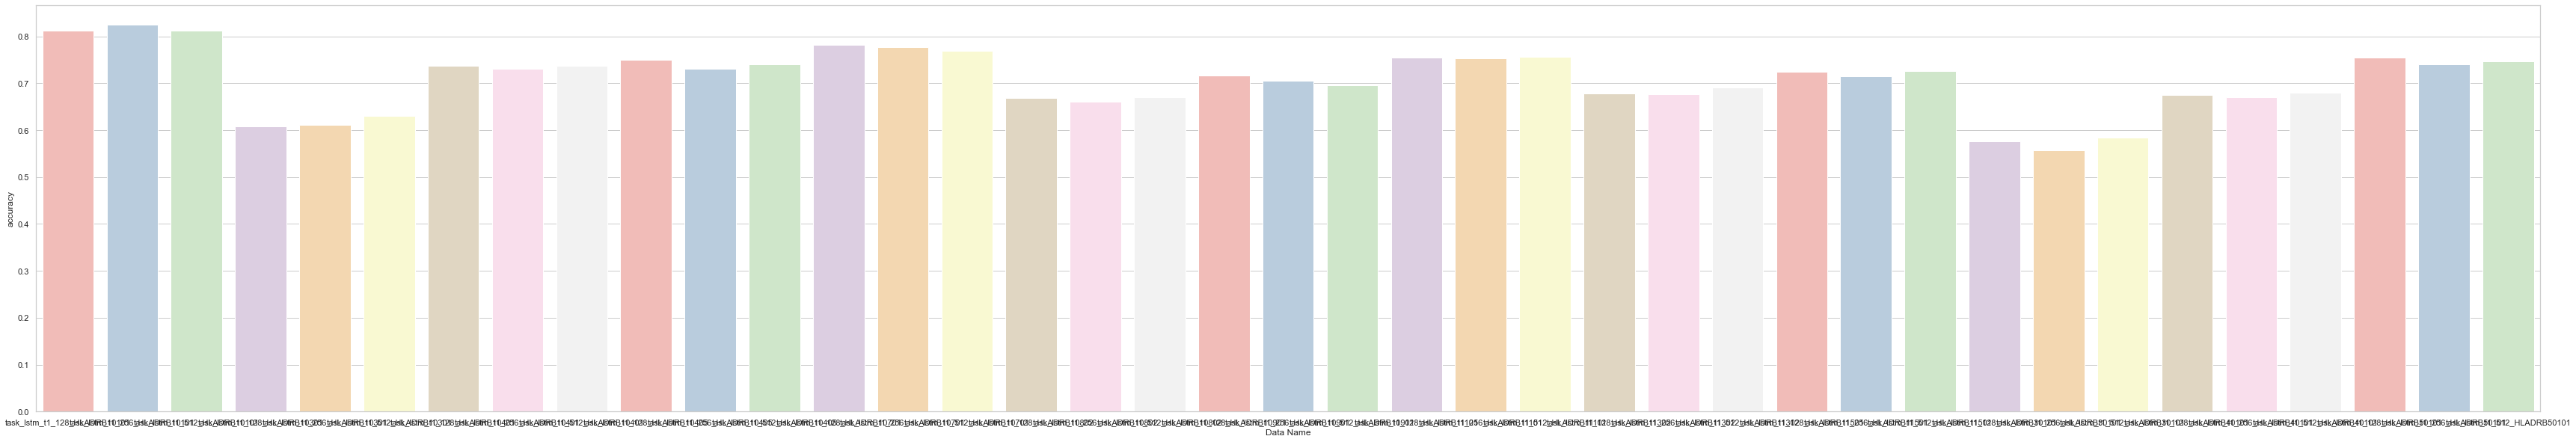

In [183]:
import seaborn as sns

plt.figure(figsize=(60, 10))
sns.barplot(x="Data Name", y="accuracy", data=total_HLAre, palette="Pastel1")

# Recall

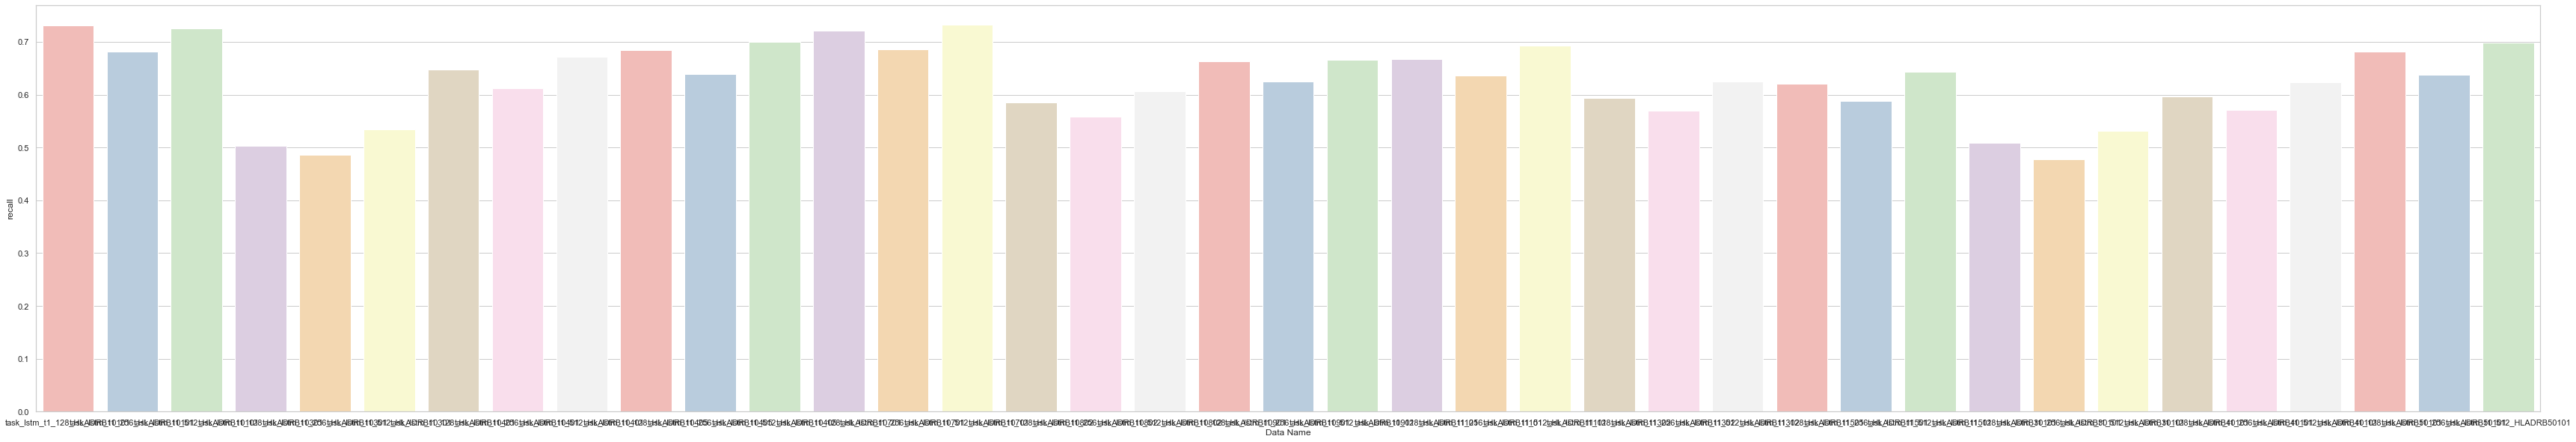

In [184]:
plt.figure(figsize=(60, 10))
sns.barplot(x="Data Name", y="recall", data=total_HLAre, palette="Pastel1")

# Precision

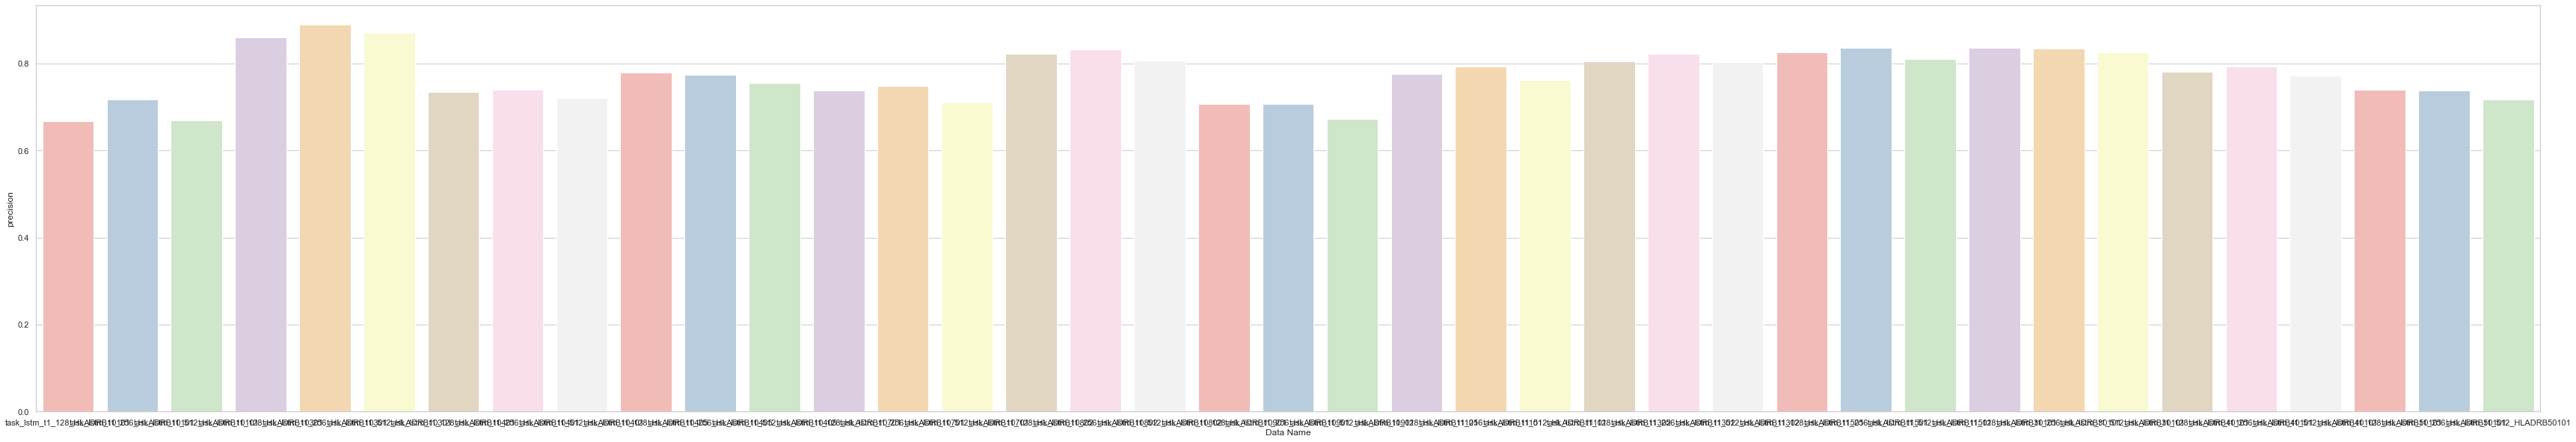

In [185]:
plt.figure(figsize=(60, 10))
sns.barplot(x="Data Name", y="precision", data=total_HLAre, palette="Pastel1")

# F1-score

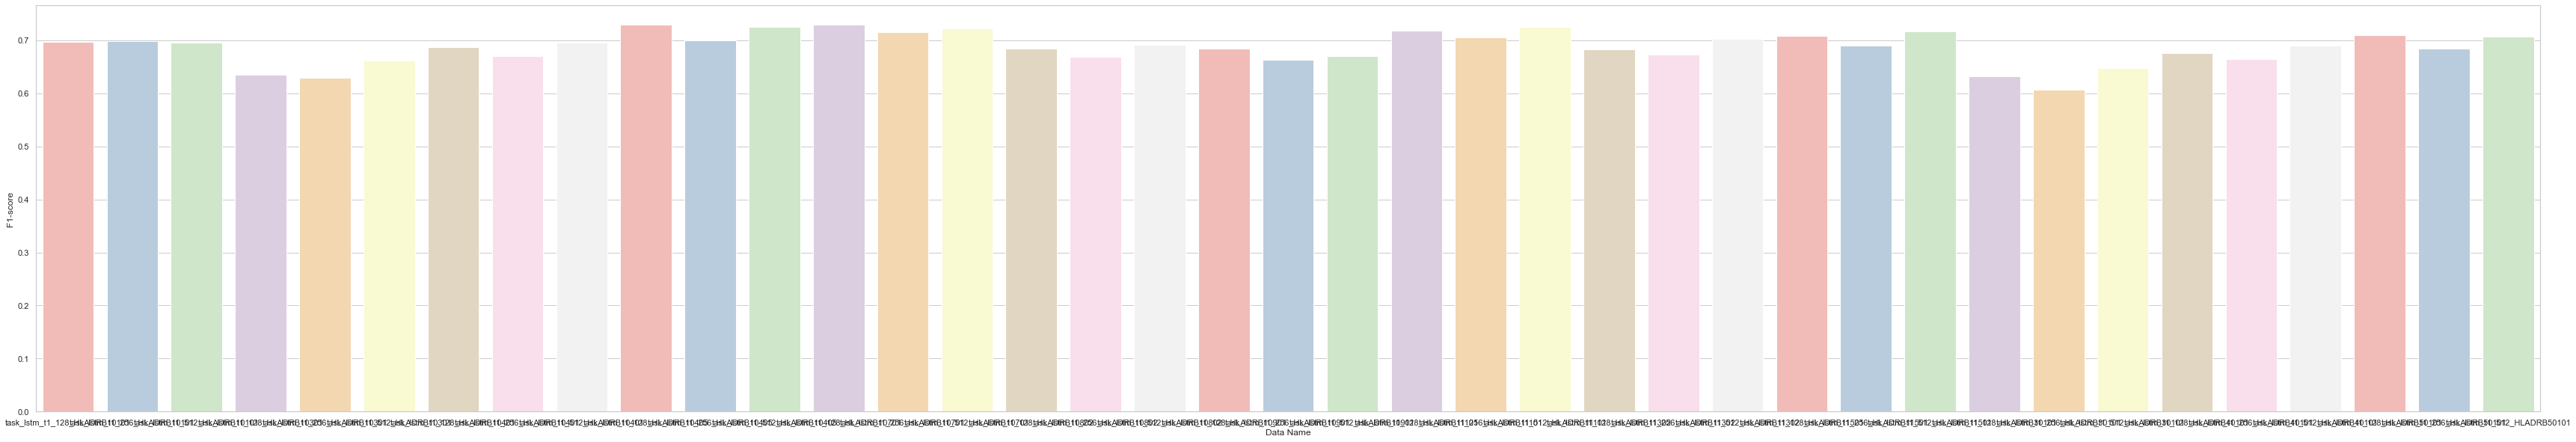

In [186]:
plt.figure(figsize=(60, 10))
sns.barplot(x="Data Name", y="F1-score", data=total_HLAre, palette="Pastel1")

# AUC-ROC

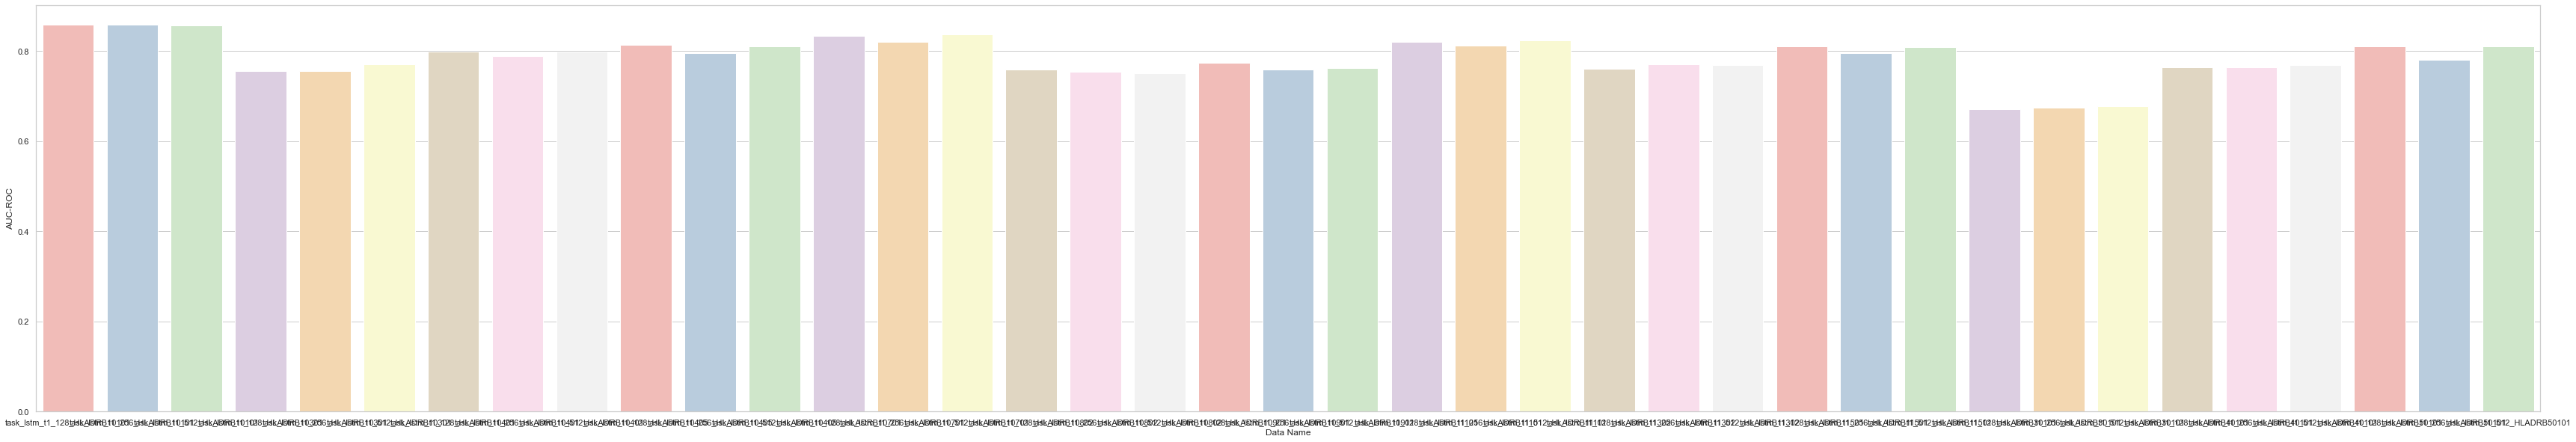

In [187]:
plt.figure(figsize=(60, 10))
sns.barplot(x="Data Name", y="AUC-ROC", data=total_HLAre, palette="Pastel1")

# Bi-LSTM

In [31]:
model = keras.models.load_model('{Path_to_h5_file}/modal_lstm_model11.hdf5')

In [96]:
t = model.predict([HLADRB10101test_v1, HLADRB10101test_v_MHC1], verbose=0)
t = pd.DataFrame(t)
t = t[0]

test = pd.DataFrame(HLADRB10101test_label)
test = test[0]

TP = K.sum(K.round(test* t))
TN = K.sum(K.cast(K.equal(K.round(test+ t), 0), K.floatx()))
FP = K.sum(K.cast(K.equal(K.round(t) - test, 1), K.floatx()))
FN = K.sum(K.cast(K.equal(test- K.round(t), 1), K.floatx()))

accuracy = (TP+TN)/(TP+FN+FP+TN)
recall = TP/(TP+FN)
precision = TP/(TP+FP)
F1 = (2*precision*recall)/(precision + recall)
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(test, t)
modal_lstm_model11_HLADRB10101re = [TP, TN, FP, FN, accuracy, recall, precision, F1, roc_auc]
modal_lstm_model11_HLADRB10101re = pd.DataFrame(modal_lstm_model11_HLADRB10101re).T
modal_lstm_model11_HLADRB10101re.columns = ['TP', 'TN', 'FP', 'FN', 'accuracy', 'recall', 'precision', 'F1-score', 'AUC-ROC']
display(modal_lstm_model11_HLADRB10101re)

,TP,TN,FP,FN,accuracy,recall,precision,F1-score,AUC-ROC
0,1066.0,3702.0,817.0,842.0,0.74187,0.5587,0.566118,0.562385,0.730374


In [97]:
t = model.predict([HLADRB10301test_v1, HLADRB10301test_v_MHC1], verbose=0)
t = pd.DataFrame(t)
t = t[0]

test = pd.DataFrame(HLADRB10301test_label)
test = test[0]

TP = K.sum(K.round(test* t))
TN = K.sum(K.cast(K.equal(K.round(test+ t), 0), K.floatx()))
FP = K.sum(K.cast(K.equal(K.round(t) - test, 1), K.floatx()))
FN = K.sum(K.cast(K.equal(test- K.round(t), 1), K.floatx()))

accuracy = (TP+TN)/(TP+FN+FP+TN)
recall = TP/(TP+FN)
precision = TP/(TP+FP)
F1 = (2*precision*recall)/(precision + recall)
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(test, t)
modal_lstm_model11_HLADRB10301re = [TP, TN, FP, FN, accuracy, recall, precision, F1, roc_auc]
modal_lstm_model11_HLADRB10301re = pd.DataFrame(modal_lstm_model11_HLADRB10301re).T
modal_lstm_model11_HLADRB10301re.columns = ['TP', 'TN', 'FP', 'FN', 'accuracy', 'recall', 'precision', 'F1-score', 'AUC-ROC']
display(modal_lstm_model11_HLADRB10301re)

,TP,TN,FP,FN,accuracy,recall,precision,F1-score,AUC-ROC
0,699.0,350.0,203.0,463.0,0.611662,0.601549,0.774945,0.677326,0.661033


In [98]:
t = model.predict([HLADRB10401test_v1, HLADRB10401test_v_MHC1], verbose=0)
t = pd.DataFrame(t)
t = t[0]

test = pd.DataFrame(HLADRB10401test_label)
test = test[0]

TP = K.sum(K.round(test* t))
TN = K.sum(K.cast(K.equal(K.round(test+ t), 0), K.floatx()))
FP = K.sum(K.cast(K.equal(K.round(t) - test, 1), K.floatx()))
FN = K.sum(K.cast(K.equal(test- K.round(t), 1), K.floatx()))

accuracy = (TP+TN)/(TP+FN+FP+TN)
recall = TP/(TP+FN)
precision = TP/(TP+FP)
F1 = (2*precision*recall)/(precision + recall)
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(test, t)
modal_lstm_model11_HLADRB10401re = [TP, TN, FP, FN, accuracy, recall, precision, F1, roc_auc]
modal_lstm_model11_HLADRB10401re = pd.DataFrame(modal_lstm_model11_HLADRB10401re).T
modal_lstm_model11_HLADRB10401re.columns = ['TP', 'TN', 'FP', 'FN', 'accuracy', 'recall', 'precision', 'F1-score', 'AUC-ROC']
display(modal_lstm_model11_HLADRB10401re)

,TP,TN,FP,FN,accuracy,recall,precision,F1-score,AUC-ROC
0,368.0,808.0,170.0,423.0,0.664782,0.465234,0.684015,0.5538,0.708785


In [32]:
t = model.predict([HLADRB10404test_v1, HLADRB10404test_v_MHC1], verbose=0)
t = pd.DataFrame(t)
t = t[0]

test = pd.DataFrame(HLADRB10404test_label)
test = test[0]

TP = K.sum(K.round(test* t))
TN = K.sum(K.cast(K.equal(K.round(test+ t), 0), K.floatx()))
FP = K.sum(K.cast(K.equal(K.round(t) - test, 1), K.floatx()))
FN = K.sum(K.cast(K.equal(test- K.round(t), 1), K.floatx()))

accuracy = (TP+TN)/(TP+FN+FP+TN)
recall = TP/(TP+FN)
precision = TP/(TP+FP)
F1 = (2*precision*recall)/(precision + recall)
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(test, t)
modal_lstm_model11_HLADRB10404re = [TP, TN, FP, FN, accuracy, recall, precision, F1, roc_auc]
modal_lstm_model11_HLADRB10404re = pd.DataFrame(modal_lstm_model11_HLADRB10404re).T
modal_lstm_model11_HLADRB10404re.columns = ['TP', 'TN', 'FP', 'FN', 'accuracy', 'recall', 'precision', 'F1-score', 'AUC-ROC']
display(modal_lstm_model11_HLADRB10404re)

,TP,TN,FP,FN,accuracy,recall,precision,F1-score,AUC-ROC
0,82.0,304.0,92.0,99.0,0.668977,0.453039,0.471264,0.461972,0.65351


In [99]:
t = model.predict([HLADRB10405test_v1, HLADRB10405test_v_MHC1], verbose=0)
t = pd.DataFrame(t)
t = t[0]

test = pd.DataFrame(HLADRB10405test_label)
test = test[0]

TP = K.sum(K.round(test* t))
TN = K.sum(K.cast(K.equal(K.round(test+ t), 0), K.floatx()))
FP = K.sum(K.cast(K.equal(K.round(t) - test, 1), K.floatx()))
FN = K.sum(K.cast(K.equal(test- K.round(t), 1), K.floatx()))

accuracy = (TP+TN)/(TP+FN+FP+TN)
recall = TP/(TP+FN)
precision = TP/(TP+FP)
F1 = (2*precision*recall)/(precision + recall)
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(test, t)
modal_lstm_model11_HLADRB10405re = [TP, TN, FP, FN, accuracy, recall, precision, F1, roc_auc]
modal_lstm_model11_HLADRB10405re = pd.DataFrame(modal_lstm_model11_HLADRB10405re).T
modal_lstm_model11_HLADRB10405re.columns = ['TP', 'TN', 'FP', 'FN', 'accuracy', 'recall', 'precision', 'F1-score', 'AUC-ROC']
display(modal_lstm_model11_HLADRB10405re)

,TP,TN,FP,FN,accuracy,recall,precision,F1-score,AUC-ROC
0,411.0,615.0,191.0,365.0,0.648546,0.529639,0.682724,0.596517,0.696468


In [100]:
t = model.predict([HLADRB10701test_v1, HLADRB10701test_v_MHC1], verbose=0)
t = pd.DataFrame(t)
t = t[0]

test = pd.DataFrame(HLADRB10701test_label)
test = test[0]

TP = K.sum(K.round(test* t))
TN = K.sum(K.cast(K.equal(K.round(test+ t), 0), K.floatx()))
FP = K.sum(K.cast(K.equal(K.round(t) - test, 1), K.floatx()))
FN = K.sum(K.cast(K.equal(test- K.round(t), 1), K.floatx()))

accuracy = (TP+TN)/(TP+FN+FP+TN)
recall = TP/(TP+FN)
precision = TP/(TP+FP)
F1 = (2*precision*recall)/(precision + recall)
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(test, t)
modal_lstm_model11_HLADRB10701re = [TP, TN, FP, FN, accuracy, recall, precision, F1, roc_auc]
modal_lstm_model11_HLADRB10701re = pd.DataFrame(modal_lstm_model11_HLADRB10701re).T
modal_lstm_model11_HLADRB10701re.columns = ['TP', 'TN', 'FP', 'FN', 'accuracy', 'recall', 'precision', 'F1-score', 'AUC-ROC']
display(modal_lstm_model11_HLADRB10701re)

,TP,TN,FP,FN,accuracy,recall,precision,F1-score,AUC-ROC
0,332.0,830.0,203.0,380.0,0.665903,0.466292,0.620561,0.532478,0.673955


In [101]:
t = model.predict([HLADRB10802test_v1, HLADRB10802test_v_MHC1], verbose=0)
t = pd.DataFrame(t)
t = t[0]

test = pd.DataFrame(HLADRB10802test_label)
test = test[0]

TP = K.sum(K.round(test* t))
TN = K.sum(K.cast(K.equal(K.round(test+ t), 0), K.floatx()))
FP = K.sum(K.cast(K.equal(K.round(t) - test, 1), K.floatx()))
FN = K.sum(K.cast(K.equal(test- K.round(t), 1), K.floatx()))

accuracy = (TP+TN)/(TP+FN+FP+TN)
recall = TP/(TP+FN)
precision = TP/(TP+FP)
F1 = (2*precision*recall)/(precision + recall)
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(test, t)
modal_lstm_model11_HLADRB10802re = [TP, TN, FP, FN, accuracy, recall, precision, F1, roc_auc]
modal_lstm_model11_HLADRB10802re = pd.DataFrame(modal_lstm_model11_HLADRB10802re).T
modal_lstm_model11_HLADRB10802re.columns = ['TP', 'TN', 'FP', 'FN', 'accuracy', 'recall', 'precision', 'F1-score', 'AUC-ROC']
display(modal_lstm_model11_HLADRB10802re)

,TP,TN,FP,FN,accuracy,recall,precision,F1-score,AUC-ROC
0,534.0,405.0,186.0,395.0,0.617763,0.574812,0.741667,0.647665,0.676605


In [102]:
t = model.predict([HLADRB10901test_v1, HLADRB10901test_v_MHC1], verbose=0)
t = pd.DataFrame(t)
t = t[0]

test = pd.DataFrame(HLADRB10901test_label)
test = test[0]

TP = K.sum(K.round(test* t))
TN = K.sum(K.cast(K.equal(K.round(test+ t), 0), K.floatx()))
FP = K.sum(K.cast(K.equal(K.round(t) - test, 1), K.floatx()))
FN = K.sum(K.cast(K.equal(test- K.round(t), 1), K.floatx()))

accuracy = (TP+TN)/(TP+FN+FP+TN)
recall = TP/(TP+FN)
precision = TP/(TP+FP)
F1 = (2*precision*recall)/(precision + recall)
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(test, t)
modal_lstm_model11_HLADRB10901re = [TP, TN, FP, FN, accuracy, recall, precision, F1, roc_auc]
modal_lstm_model11_HLADRB10901re = pd.DataFrame(modal_lstm_model11_HLADRB10901re).T
modal_lstm_model11_HLADRB10901re.columns = ['TP', 'TN', 'FP', 'FN', 'accuracy', 'recall', 'precision', 'F1-score', 'AUC-ROC']
display(modal_lstm_model11_HLADRB10901re)

,TP,TN,FP,FN,accuracy,recall,precision,F1-score,AUC-ROC
0,373.0,606.0,209.0,332.0,0.644079,0.529078,0.640893,0.579643,0.682221


In [103]:
t = model.predict([HLADRB11101test_v1, HLADRB11101test_v_MHC1], verbose=0)
t = pd.DataFrame(t)
t = t[0]

test = pd.DataFrame(HLADRB11101test_label)
test = test[0]

TP = K.sum(K.round(test* t))
TN = K.sum(K.cast(K.equal(K.round(test+ t), 0), K.floatx()))
FP = K.sum(K.cast(K.equal(K.round(t) - test, 1), K.floatx()))
FN = K.sum(K.cast(K.equal(test- K.round(t), 1), K.floatx()))

accuracy = (TP+TN)/(TP+FN+FP+TN)
recall = TP/(TP+FN)
precision = TP/(TP+FP)
F1 = (2*precision*recall)/(precision + recall)
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(test, t)
modal_lstm_model11_HLADRB11101re = [TP, TN, FP, FN, accuracy, recall, precision, F1, roc_auc]
modal_lstm_model11_HLADRB11101re = pd.DataFrame(modal_lstm_model11_HLADRB11101re).T
modal_lstm_model11_HLADRB11101re.columns = ['TP', 'TN', 'FP', 'FN', 'accuracy', 'recall', 'precision', 'F1-score', 'AUC-ROC']
display(modal_lstm_model11_HLADRB11101re)

,TP,TN,FP,FN,accuracy,recall,precision,F1-score,AUC-ROC
0,443.0,743.0,214.0,394.0,0.661093,0.529271,0.674277,0.593039,0.698446


In [104]:
t = model.predict([HLADRB11302test_v1, HLADRB11302test_v_MHC1], verbose=0)
t = pd.DataFrame(t)
t = t[0]

test = pd.DataFrame(HLADRB11302test_label)
test = test[0]

TP = K.sum(K.round(test* t))
TN = K.sum(K.cast(K.equal(K.round(test+ t), 0), K.floatx()))
FP = K.sum(K.cast(K.equal(K.round(t) - test, 1), K.floatx()))
FN = K.sum(K.cast(K.equal(test- K.round(t), 1), K.floatx()))

accuracy = (TP+TN)/(TP+FN+FP+TN)
recall = TP/(TP+FN)
precision = TP/(TP+FP)
F1 = (2*precision*recall)/(precision + recall)
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(test, t)
modal_lstm_model11_HLADRB11302re = [TP, TN, FP, FN, accuracy, recall, precision, F1, roc_auc]
modal_lstm_model11_HLADRB11302re = pd.DataFrame(modal_lstm_model11_HLADRB11302re).T
modal_lstm_model11_HLADRB11302re.columns = ['TP', 'TN', 'FP', 'FN', 'accuracy', 'recall', 'precision', 'F1-score', 'AUC-ROC']
display(modal_lstm_model11_HLADRB11302re)

,TP,TN,FP,FN,accuracy,recall,precision,F1-score,AUC-ROC
0,382.0,528.0,128.0,542.0,0.575949,0.41342,0.74902,0.532775,0.652899


In [105]:
t = model.predict([HLADRB11501test_v1, HLADRB11501test_v_MHC1], verbose=0)
t = pd.DataFrame(t)
t = t[0]

test = pd.DataFrame(HLADRB11501test_label)
test = test[0]

TP = K.sum(K.round(test* t))
TN = K.sum(K.cast(K.equal(K.round(test+ t), 0), K.floatx()))
FP = K.sum(K.cast(K.equal(K.round(t) - test, 1), K.floatx()))
FN = K.sum(K.cast(K.equal(test- K.round(t), 1), K.floatx()))

accuracy = (TP+TN)/(TP+FN+FP+TN)
recall = TP/(TP+FN)
precision = TP/(TP+FP)
F1 = (2*precision*recall)/(precision + recall)
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(test, t)
modal_lstm_model11_HLADRB11501re = [TP, TN, FP, FN, accuracy, recall, precision, F1, roc_auc]
modal_lstm_model11_HLADRB11501re = pd.DataFrame(modal_lstm_model11_HLADRB11501re).T
modal_lstm_model11_HLADRB11501re.columns = ['TP', 'TN', 'FP', 'FN', 'accuracy', 'recall', 'precision', 'F1-score', 'AUC-ROC']
display(modal_lstm_model11_HLADRB11501re)

,TP,TN,FP,FN,accuracy,recall,precision,F1-score,AUC-ROC
0,470.0,630.0,185.0,484.0,0.62182,0.492662,0.717557,0.584214,0.673824


In [106]:
t = model.predict([HLADRB30101test_v1, HLADRB30101test_v_MHC1], verbose=0)
t = pd.DataFrame(t)
t = t[0]

test = pd.DataFrame(HLADRB30101test_label)
test = test[0]

TP = K.sum(K.round(test* t))
TN = K.sum(K.cast(K.equal(K.round(test+ t), 0), K.floatx()))
FP = K.sum(K.cast(K.equal(K.round(t) - test, 1), K.floatx()))
FN = K.sum(K.cast(K.equal(test- K.round(t), 1), K.floatx()))

accuracy = (TP+TN)/(TP+FN+FP+TN)
recall = TP/(TP+FN)
precision = TP/(TP+FP)
F1 = (2*precision*recall)/(precision + recall)
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(test, t)
modal_lstm_model11_HLADRB30101re = [TP, TN, FP, FN, accuracy, recall, precision, F1, roc_auc]
modal_lstm_model11_HLADRB30101re = pd.DataFrame(modal_lstm_model11_HLADRB30101re).T
modal_lstm_model11_HLADRB30101re.columns = ['TP', 'TN', 'FP', 'FN', 'accuracy', 'recall', 'precision', 'F1-score', 'AUC-ROC']
display(modal_lstm_model11_HLADRB30101re)

,TP,TN,FP,FN,accuracy,recall,precision,F1-score,AUC-ROC
0,462.0,311.0,115.0,613.0,0.51499,0.429767,0.800693,0.559322,0.607034


In [107]:
t = model.predict([HLADRB40101test_v1, HLADRB40101test_v_MHC1], verbose=0)
t = pd.DataFrame(t)
t = t[0]

test = pd.DataFrame(HLADRB40101test_label)
test = test[0]

TP = K.sum(K.round(test* t))
TN = K.sum(K.cast(K.equal(K.round(test+ t), 0), K.floatx()))
FP = K.sum(K.cast(K.equal(K.round(t) - test, 1), K.floatx()))
FN = K.sum(K.cast(K.equal(test- K.round(t), 1), K.floatx()))

accuracy = (TP+TN)/(TP+FN+FP+TN)
recall = TP/(TP+FN)
precision = TP/(TP+FP)
F1 = (2*precision*recall)/(precision + recall)
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(test, t)
modal_lstm_model11_HLADRB40101re = [TP, TN, FP, FN, accuracy, recall, precision, F1, roc_auc]
modal_lstm_model11_HLADRB40101re = pd.DataFrame(modal_lstm_model11_HLADRB40101re).T
modal_lstm_model11_HLADRB40101re.columns = ['TP', 'TN', 'FP', 'FN', 'accuracy', 'recall', 'precision', 'F1-score', 'AUC-ROC']
display(modal_lstm_model11_HLADRB40101re)

,TP,TN,FP,FN,accuracy,recall,precision,F1-score,AUC-ROC
0,402.0,476.0,178.0,465.0,0.577252,0.463668,0.693103,0.555632,0.620777


In [108]:
t = model.predict([HLADRB50101test_v1, HLADRB50101test_v_MHC1], verbose=0)
t = pd.DataFrame(t)
t = t[0]

test = pd.DataFrame(HLADRB50101test_label)
test = test[0]

TP = K.sum(K.round(test* t))
TN = K.sum(K.cast(K.equal(K.round(test+ t), 0), K.floatx()))
FP = K.sum(K.cast(K.equal(K.round(t) - test, 1), K.floatx()))
FN = K.sum(K.cast(K.equal(test- K.round(t), 1), K.floatx()))

accuracy = (TP+TN)/(TP+FN+FP+TN)
recall = TP/(TP+FN)
precision = TP/(TP+FP)
F1 = (2*precision*recall)/(precision + recall)
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(test, t)
modal_lstm_model11_HLADRB50101re = [TP, TN, FP, FN, accuracy, recall, precision, F1, roc_auc]
modal_lstm_model11_HLADRB50101re = pd.DataFrame(modal_lstm_model11_HLADRB50101re).T
modal_lstm_model11_HLADRB50101re.columns = ['TP', 'TN', 'FP', 'FN', 'accuracy', 'recall', 'precision', 'F1-score', 'AUC-ROC']
display(modal_lstm_model11_HLADRB50101re)

,TP,TN,FP,FN,accuracy,recall,precision,F1-score,AUC-ROC
0,423.0,763.0,229.0,354.0,0.670435,0.544402,0.648773,0.592022,0.710648


# Multi-head

In [33]:
def bilstmc2_model(out_dim, dropoutrate, lay_num):
    encoder_input = Input(shape=(None,)) # encoderの入力層
    decoder_input = Input(shape=(None,)) # decoderの入力層
    
    encoder_emb = Embedding(47, 100, input_length=39, weights=[monovec], trainable=False)(encoder_input)
    decoder_emb = Embedding(9419, 100, input_length=230, weights=[trivec1_MHC], trainable=False)(decoder_input)
    
    # encoder
    encoder_output1 = MultiHead(
        layer=keras.layers.Bidirectional(keras.layers.LSTM(out_dim, dropout=dropoutrate), name='LSTM'),
        layer_num=lay_num,
        reg_index=[1, 4],
        reg_slice=(slice(None, None), slice(128, 96)),
        reg_factor=0.1,
        name='Multi-Head-Attention1',
    )(encoder_emb)
    peptide_output1 = keras.layers.Flatten(name='Flatten1')(encoder_output1)
    
    # decoder
    decoder_output1 = MultiHead(
        layer=keras.layers.Bidirectional(keras.layers.LSTM(out_dim, dropout=dropoutrate), name='LSTM'),
        layer_num=lay_num,
        reg_index=[1, 4],
        reg_slice=(slice(None, None), slice(128, 96)),
        reg_factor=0.1,
        name='Multi-Head-Attention2',
    )(decoder_emb)
    MHC_output1 = keras.layers.Flatten(name='Flatten2')(decoder_output1)
    
    conc = layers.concatenate([peptide_output1, MHC_output1], axis=-1)
    out = Dense(2, activation='softmax')(conc)
    
    model = Model([encoder_input, decoder_input], out)  # 入力と出力を設定し、Modelクラスでモデルを作成
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
    return model

In [34]:
model = bilstmc2_model(out_dim=512, dropoutrate=0.7, lay_num=4)
model.load_weights('{Path_to_h5_file}/modal_head16_weights.h5')

In [111]:
t = model.predict([HLADRB10101test_v1, HLADRB10101test_v_MHC1], verbose=0)
t = pd.DataFrame(t)
t = t[0]

test = pd.DataFrame(HLADRB10101test_label)
test = test[0]

TP = K.sum(K.round(test* t))
TN = K.sum(K.cast(K.equal(K.round(test+ t), 0), K.floatx()))
FP = K.sum(K.cast(K.equal(K.round(t) - test, 1), K.floatx()))
FN = K.sum(K.cast(K.equal(test- K.round(t), 1), K.floatx()))

accuracy = (TP+TN)/(TP+FN+FP+TN)
recall = TP/(TP+FN)
precision = TP/(TP+FP)
F1 = (2*precision*recall)/(precision + recall)
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(test, t)
modal_head16_HLADRB10101re = [TP, TN, FP, FN, accuracy, recall, precision, F1, roc_auc]
modal_head16_HLADRB10101re = pd.DataFrame(modal_head16_HLADRB10101re).T
modal_head16_HLADRB10101re.columns = ['TP', 'TN', 'FP', 'FN', 'accuracy', 'recall', 'precision', 'F1-score', 'AUC-ROC']
display(modal_head16_HLADRB10101re)

,TP,TN,FP,FN,accuracy,recall,precision,F1-score,AUC-ROC
0,1172.0,4350.0,169.0,736.0,0.859188,0.614256,0.873975,0.721453,0.904458


In [112]:
t = model.predict([HLADRB10301test_v1, HLADRB10301test_v_MHC1], verbose=0)
t = pd.DataFrame(t)
t = t[0]

test = pd.DataFrame(HLADRB10301test_label)
test = test[0]

TP = K.sum(K.round(test* t))
TN = K.sum(K.cast(K.equal(K.round(test+ t), 0), K.floatx()))
FP = K.sum(K.cast(K.equal(K.round(t) - test, 1), K.floatx()))
FN = K.sum(K.cast(K.equal(test- K.round(t), 1), K.floatx()))

accuracy = (TP+TN)/(TP+FN+FP+TN)
recall = TP/(TP+FN)
precision = TP/(TP+FP)
F1 = (2*precision*recall)/(precision + recall)
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(test, t)
modal_head16_HLADRB10301re = [TP, TN, FP, FN, accuracy, recall, precision, F1, roc_auc]
modal_head16_HLADRB10301re = pd.DataFrame(modal_head16_HLADRB10301re).T
modal_head16_HLADRB10301re.columns = ['TP', 'TN', 'FP', 'FN', 'accuracy', 'recall', 'precision', 'F1-score', 'AUC-ROC']
display(modal_head16_HLADRB10301re)

,TP,TN,FP,FN,accuracy,recall,precision,F1-score,AUC-ROC
0,612.0,460.0,93.0,550.0,0.625073,0.526678,0.868085,0.655597,0.748455


In [113]:
t = model.predict([HLADRB10401test_v1, HLADRB10401test_v_MHC1], verbose=0)
t = pd.DataFrame(t)
t = t[0]

test = pd.DataFrame(HLADRB10401test_label)
test = test[0]

TP = K.sum(K.round(test* t))
TN = K.sum(K.cast(K.equal(K.round(test+ t), 0), K.floatx()))
FP = K.sum(K.cast(K.equal(K.round(t) - test, 1), K.floatx()))
FN = K.sum(K.cast(K.equal(test- K.round(t), 1), K.floatx()))

accuracy = (TP+TN)/(TP+FN+FP+TN)
recall = TP/(TP+FN)
precision = TP/(TP+FP)
F1 = (2*precision*recall)/(precision + recall)
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(test, t)
modal_head16_HLADRB10401re = [TP, TN, FP, FN, accuracy, recall, precision, F1, roc_auc]
modal_head16_HLADRB10401re = pd.DataFrame(modal_head16_HLADRB10401re).T
modal_head16_HLADRB10401re.columns = ['TP', 'TN', 'FP', 'FN', 'accuracy', 'recall', 'precision', 'F1-score', 'AUC-ROC']
display(modal_head16_HLADRB10401re)

,TP,TN,FP,FN,accuracy,recall,precision,F1-score,AUC-ROC
0,372.0,893.0,85.0,419.0,0.715093,0.470291,0.814004,0.596154,0.790761


In [35]:
t = model.predict([HLADRB10404test_v1, HLADRB10404test_v_MHC1], verbose=0)
t = pd.DataFrame(t)
t = t[0]

test = pd.DataFrame(HLADRB10404test_label)
test = test[0]

TP = K.sum(K.round(test* t))
TN = K.sum(K.cast(K.equal(K.round(test+ t), 0), K.floatx()))
FP = K.sum(K.cast(K.equal(K.round(t) - test, 1), K.floatx()))
FN = K.sum(K.cast(K.equal(test- K.round(t), 1), K.floatx()))

accuracy = (TP+TN)/(TP+FN+FP+TN)
recall = TP/(TP+FN)
precision = TP/(TP+FP)
F1 = (2*precision*recall)/(precision + recall)
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(test, t)
modal_head16_HLADRB10404re = [TP, TN, FP, FN, accuracy, recall, precision, F1, roc_auc]
modal_head16_HLADRB10404re = pd.DataFrame(modal_head16_HLADRB10404re).T
modal_head16_HLADRB10404re.columns = ['TP', 'TN', 'FP', 'FN', 'accuracy', 'recall', 'precision', 'F1-score', 'AUC-ROC']
display(modal_head16_HLADRB10404re)

,TP,TN,FP,FN,accuracy,recall,precision,F1-score,AUC-ROC
0,65.0,384.0,12.0,116.0,0.778163,0.359116,0.844156,0.503876,0.812392


In [114]:
t = model.predict([HLADRB10405test_v1, HLADRB10405test_v_MHC1], verbose=0)
t = pd.DataFrame(t)
t = t[0]

test = pd.DataFrame(HLADRB10405test_label)
test = test[0]

TP = K.sum(K.round(test* t))
TN = K.sum(K.cast(K.equal(K.round(test+ t), 0), K.floatx()))
FP = K.sum(K.cast(K.equal(K.round(t) - test, 1), K.floatx()))
FN = K.sum(K.cast(K.equal(test- K.round(t), 1), K.floatx()))

accuracy = (TP+TN)/(TP+FN+FP+TN)
recall = TP/(TP+FN)
precision = TP/(TP+FP)
F1 = (2*precision*recall)/(precision + recall)
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(test, t)
modal_head16_HLADRB10405re = [TP, TN, FP, FN, accuracy, recall, precision, F1, roc_auc]
modal_head16_HLADRB10405re = pd.DataFrame(modal_head16_HLADRB10405re).T
modal_head16_HLADRB10405re.columns = ['TP', 'TN', 'FP', 'FN', 'accuracy', 'recall', 'precision', 'F1-score', 'AUC-ROC']
display(modal_head16_HLADRB10405re)

,TP,TN,FP,FN,accuracy,recall,precision,F1-score,AUC-ROC
0,444.0,705.0,101.0,332.0,0.726296,0.572165,0.814679,0.672218,0.810342


In [115]:
t = model.predict([HLADRB10701test_v1, HLADRB10701test_v_MHC1], verbose=0)
t = pd.DataFrame(t)
t = t[0]

test = pd.DataFrame(HLADRB10701test_label)
test = test[0]

TP = K.sum(K.round(test* t))
TN = K.sum(K.cast(K.equal(K.round(test+ t), 0), K.floatx()))
FP = K.sum(K.cast(K.equal(K.round(t) - test, 1), K.floatx()))
FN = K.sum(K.cast(K.equal(test- K.round(t), 1), K.floatx()))

accuracy = (TP+TN)/(TP+FN+FP+TN)
recall = TP/(TP+FN)
precision = TP/(TP+FP)
F1 = (2*precision*recall)/(precision + recall)
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(test, t)
modal_head16_HLADRB10701re = [TP, TN, FP, FN, accuracy, recall, precision, F1, roc_auc]
modal_head16_HLADRB10701re = pd.DataFrame(modal_head16_HLADRB10701re).T
modal_head16_HLADRB10701re.columns = ['TP', 'TN', 'FP', 'FN', 'accuracy', 'recall', 'precision', 'F1-score', 'AUC-ROC']
display(modal_head16_HLADRB10701re)

,TP,TN,FP,FN,accuracy,recall,precision,F1-score,AUC-ROC
0,369.0,969.0,64.0,343.0,0.766762,0.518258,0.852194,0.644542,0.826626


In [116]:
t = model.predict([HLADRB10802test_v1, HLADRB10802test_v_MHC1], verbose=0)
t = pd.DataFrame(t)
t = t[0]

test = pd.DataFrame(HLADRB10802test_label)
test = test[0]

TP = K.sum(K.round(test* t))
TN = K.sum(K.cast(K.equal(K.round(test+ t), 0), K.floatx()))
FP = K.sum(K.cast(K.equal(K.round(t) - test, 1), K.floatx()))
FN = K.sum(K.cast(K.equal(test- K.round(t), 1), K.floatx()))

accuracy = (TP+TN)/(TP+FN+FP+TN)
recall = TP/(TP+FN)
precision = TP/(TP+FP)
F1 = (2*precision*recall)/(precision + recall)
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(test, t)
modal_head16_HLADRB10802re = [TP, TN, FP, FN, accuracy, recall, precision, F1, roc_auc]
modal_head16_HLADRB10802re = pd.DataFrame(modal_head16_HLADRB10802re).T
modal_head16_HLADRB10802re.columns = ['TP', 'TN', 'FP', 'FN', 'accuracy', 'recall', 'precision', 'F1-score', 'AUC-ROC']
display(modal_head16_HLADRB10802re)

,TP,TN,FP,FN,accuracy,recall,precision,F1-score,AUC-ROC
0,509.0,513.0,78.0,420.0,0.672368,0.547901,0.867121,0.671504,0.759206


In [117]:
t = model.predict([HLADRB10901test_v1, HLADRB10901test_v_MHC1], verbose=0)
t = pd.DataFrame(t)
t = t[0]

test = pd.DataFrame(HLADRB10901test_label)
test = test[0]

TP = K.sum(K.round(test* t))
TN = K.sum(K.cast(K.equal(K.round(test+ t), 0), K.floatx()))
FP = K.sum(K.cast(K.equal(K.round(t) - test, 1), K.floatx()))
FN = K.sum(K.cast(K.equal(test- K.round(t), 1), K.floatx()))

accuracy = (TP+TN)/(TP+FN+FP+TN)
recall = TP/(TP+FN)
precision = TP/(TP+FP)
F1 = (2*precision*recall)/(precision + recall)
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(test, t)
modal_head16_HLADRB10901re = [TP, TN, FP, FN, accuracy, recall, precision, F1, roc_auc]
modal_head16_HLADRB10901re = pd.DataFrame(modal_head16_HLADRB10901re).T
modal_head16_HLADRB10901re.columns = ['TP', 'TN', 'FP', 'FN', 'accuracy', 'recall', 'precision', 'F1-score', 'AUC-ROC']
display(modal_head16_HLADRB10901re)

,TP,TN,FP,FN,accuracy,recall,precision,F1-score,AUC-ROC
0,407.0,691.0,124.0,298.0,0.722368,0.577305,0.766478,0.658576,0.777912


In [118]:
t = model.predict([HLADRB11101test_v1, HLADRB11101test_v_MHC1], verbose=0)
t = pd.DataFrame(t)
t = t[0]

test = pd.DataFrame(HLADRB11101test_label)
test = test[0]

TP = K.sum(K.round(test* t))
TN = K.sum(K.cast(K.equal(K.round(test+ t), 0), K.floatx()))
FP = K.sum(K.cast(K.equal(K.round(t) - test, 1), K.floatx()))
FN = K.sum(K.cast(K.equal(test- K.round(t), 1), K.floatx()))

accuracy = (TP+TN)/(TP+FN+FP+TN)
recall = TP/(TP+FN)
precision = TP/(TP+FP)
F1 = (2*precision*recall)/(precision + recall)
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(test, t)
modal_head16_HLADRB11101re = [TP, TN, FP, FN, accuracy, recall, precision, F1, roc_auc]
modal_head16_HLADRB11101re = pd.DataFrame(modal_head16_HLADRB11101re).T
modal_head16_HLADRB11101re.columns = ['TP', 'TN', 'FP', 'FN', 'accuracy', 'recall', 'precision', 'F1-score', 'AUC-ROC']
display(modal_head16_HLADRB11101re)

,TP,TN,FP,FN,accuracy,recall,precision,F1-score,AUC-ROC
0,484.0,858.0,99.0,353.0,0.748049,0.578256,0.830189,0.68169,0.827508


In [119]:
t = model.predict([HLADRB11302test_v1, HLADRB11302test_v_MHC1], verbose=0)
t = pd.DataFrame(t)
t = t[0]

test = pd.DataFrame(HLADRB11302test_label)
test = test[0]

TP = K.sum(K.round(test* t))
TN = K.sum(K.cast(K.equal(K.round(test+ t), 0), K.floatx()))
FP = K.sum(K.cast(K.equal(K.round(t) - test, 1), K.floatx()))
FN = K.sum(K.cast(K.equal(test- K.round(t), 1), K.floatx()))

accuracy = (TP+TN)/(TP+FN+FP+TN)
recall = TP/(TP+FN)
precision = TP/(TP+FP)
F1 = (2*precision*recall)/(precision + recall)
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(test, t)
modal_head16_HLADRB11302re = [TP, TN, FP, FN, accuracy, recall, precision, F1, roc_auc]
modal_head16_HLADRB11302re = pd.DataFrame(modal_head16_HLADRB11302re).T
modal_head16_HLADRB11302re.columns = ['TP', 'TN', 'FP', 'FN', 'accuracy', 'recall', 'precision', 'F1-score', 'AUC-ROC']
display(modal_head16_HLADRB11302re)

,TP,TN,FP,FN,accuracy,recall,precision,F1-score,AUC-ROC
0,470.0,568.0,88.0,454.0,0.656962,0.508658,0.842294,0.634278,0.756371


In [120]:
t = model.predict([HLADRB11501test_v1, HLADRB11501test_v_MHC1], verbose=0)
t = pd.DataFrame(t)
t = t[0]

test = pd.DataFrame(HLADRB11501test_label)
test = test[0]

TP = K.sum(K.round(test* t))
TN = K.sum(K.cast(K.equal(K.round(test+ t), 0), K.floatx()))
FP = K.sum(K.cast(K.equal(K.round(t) - test, 1), K.floatx()))
FN = K.sum(K.cast(K.equal(test- K.round(t), 1), K.floatx()))

accuracy = (TP+TN)/(TP+FN+FP+TN)
recall = TP/(TP+FN)
precision = TP/(TP+FP)
F1 = (2*precision*recall)/(precision + recall)
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(test, t)
modal_head16_HLADRB11501re = [TP, TN, FP, FN, accuracy, recall, precision, F1, roc_auc]
modal_head16_HLADRB11501re = pd.DataFrame(modal_head16_HLADRB11501re).T
modal_head16_HLADRB11501re.columns = ['TP', 'TN', 'FP', 'FN', 'accuracy', 'recall', 'precision', 'F1-score', 'AUC-ROC']
display(modal_head16_HLADRB11501re)

,TP,TN,FP,FN,accuracy,recall,precision,F1-score,AUC-ROC
0,508.0,746.0,69.0,446.0,0.708875,0.532495,0.880416,0.663619,0.8125


In [121]:
t = model.predict([HLADRB30101test_v1, HLADRB30101test_v_MHC1], verbose=0)
t = pd.DataFrame(t)
t = t[0]

test = pd.DataFrame(HLADRB30101test_label)
test = test[0]

TP = K.sum(K.round(test* t))
TN = K.sum(K.cast(K.equal(K.round(test+ t), 0), K.floatx()))
FP = K.sum(K.cast(K.equal(K.round(t) - test, 1), K.floatx()))
FN = K.sum(K.cast(K.equal(test- K.round(t), 1), K.floatx()))

accuracy = (TP+TN)/(TP+FN+FP+TN)
recall = TP/(TP+FN)
precision = TP/(TP+FP)
F1 = (2*precision*recall)/(precision + recall)
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(test, t)
modal_head16_HLADRB30101re = [TP, TN, FP, FN, accuracy, recall, precision, F1, roc_auc]
modal_head16_HLADRB30101re = pd.DataFrame(modal_head16_HLADRB30101re).T
modal_head16_HLADRB30101re.columns = ['TP', 'TN', 'FP', 'FN', 'accuracy', 'recall', 'precision', 'F1-score', 'AUC-ROC']
display(modal_head16_HLADRB30101re)

,TP,TN,FP,FN,accuracy,recall,precision,F1-score,AUC-ROC
0,446.0,346.0,80.0,629.0,0.527648,0.414884,0.847909,0.557152,0.662796


In [122]:
t = model.predict([HLADRB40101test_v1, HLADRB40101test_v_MHC1], verbose=0)
t = pd.DataFrame(t)
t = t[0]

test = pd.DataFrame(HLADRB40101test_label)
test = test[0]

TP = K.sum(K.round(test* t))
TN = K.sum(K.cast(K.equal(K.round(test+ t), 0), K.floatx()))
FP = K.sum(K.cast(K.equal(K.round(t) - test, 1), K.floatx()))
FN = K.sum(K.cast(K.equal(test- K.round(t), 1), K.floatx()))

accuracy = (TP+TN)/(TP+FN+FP+TN)
recall = TP/(TP+FN)
precision = TP/(TP+FP)
F1 = (2*precision*recall)/(precision + recall)
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(test, t)
modal_head16_HLADRB40101re = [TP, TN, FP, FN, accuracy, recall, precision, F1, roc_auc]
modal_head16_HLADRB40101re = pd.DataFrame(modal_head16_HLADRB40101re).T
modal_head16_HLADRB40101re.columns = ['TP', 'TN', 'FP', 'FN', 'accuracy', 'recall', 'precision', 'F1-score', 'AUC-ROC']
display(modal_head16_HLADRB40101re)

,TP,TN,FP,FN,accuracy,recall,precision,F1-score,AUC-ROC
0,431.0,563.0,91.0,436.0,0.653517,0.497117,0.82567,0.62059,0.768987


In [123]:
t = model.predict([HLADRB50101test_v1, HLADRB50101test_v_MHC1], verbose=0)
t = pd.DataFrame(t)
t = t[0]

test = pd.DataFrame(HLADRB50101test_label)
test = test[0]

TP = K.sum(K.round(test* t))
TN = K.sum(K.cast(K.equal(K.round(test+ t), 0), K.floatx()))
FP = K.sum(K.cast(K.equal(K.round(t) - test, 1), K.floatx()))
FN = K.sum(K.cast(K.equal(test- K.round(t), 1), K.floatx()))

accuracy = (TP+TN)/(TP+FN+FP+TN)
recall = TP/(TP+FN)
precision = TP/(TP+FP)
F1 = (2*precision*recall)/(precision + recall)
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(test, t)
modal_head16_HLADRB50101re = [TP, TN, FP, FN, accuracy, recall, precision, F1, roc_auc]
modal_head16_HLADRB50101re = pd.DataFrame(modal_head16_HLADRB50101re).T
modal_head16_HLADRB50101re.columns = ['TP', 'TN', 'FP', 'FN', 'accuracy', 'recall', 'precision', 'F1-score', 'AUC-ROC']
display(modal_head16_HLADRB50101re)

,TP,TN,FP,FN,accuracy,recall,precision,F1-score,AUC-ROC
0,439.0,874.0,118.0,338.0,0.742227,0.564994,0.788151,0.658171,0.809254
